In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

data = pd.read_csv('processed_data.csv')

# Ensure TIMESTAMP is in datetime format
if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# Creating interaction features and temporal features
data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month

# Behavioral patterns
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

# Graph-based features
G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

# Prepare data for GNN model
features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

# Normalize features
scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

# Apply SMOTE
smote = SMOTE(random_state=42)
data_x, data_y = smote.fit_resample(data_x, data_y)

In [4]:
# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Set up device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
# Train the autoencoder
def train_autoencoder(data_x, encoding_dim, num_epochs=50, learning_rate=0.001):
    input_dim = data_x.shape[1]
    autoencoder = Autoencoder(input_dim, encoding_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

    data_x_tensor = torch.tensor(data_x, dtype=torch.float).to(device)
    for epoch in range(num_epochs):
        autoencoder.train()
        optimizer.zero_grad()
        outputs = autoencoder(data_x_tensor)
        loss = criterion(outputs, data_x_tensor)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    encoded_data = autoencoder.encoder(data_x_tensor).detach().cpu().numpy()
    return encoded_data

# Encode the features
encoding_dim = 64  # You can adjust this dimension
encoded_data_x = train_autoencoder(data_x, encoding_dim)

Epoch [10/50], Loss: 0.6201
Epoch [20/50], Loss: 0.3349
Epoch [30/50], Loss: 0.1467
Epoch [40/50], Loss: 0.0631
Epoch [50/50], Loss: 0.0249


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Early stopping at epoch 97


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Early stopping at epoch 71


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Early stopping at epoch 68


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Early stopping at epoch 75


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Early stopping at epoch 87


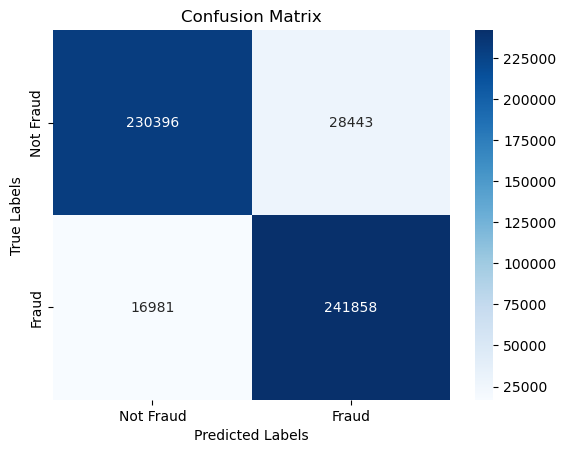

Cross-validated metrics:
AUC: 0.9769 ± 0.0080
Accuracy: 0.9123 ± 0.0266
Precision: 0.8989 ± 0.0536
Recall: 0.9344 ± 0.0226
F1 Score: 0.9149 ± 0.0228


In [7]:
# Convert to torch tensors
encoded_data_x = torch.tensor(encoded_data_x, dtype=torch.float)
data_y = torch.tensor(data_y, dtype=torch.float).unsqueeze(1)

# Create edge_index for PyG data object
unique_nodes = pd.Index(data['SENDER_ACCOUNT_ID'].append(data['RECEIVER_ACCOUNT_ID']).unique())
node_mapping = {node: i for i, node in enumerate(unique_nodes)}
data['SENDER_ID_REINDEX'] = data['SENDER_ACCOUNT_ID'].map(node_mapping)
data['RECEIVER_ID_REINDEX'] = data['RECEIVER_ACCOUNT_ID'].map(node_mapping)
edge_index = torch.tensor([data['SENDER_ID_REINDEX'].values, data['RECEIVER_ID_REINDEX'].values], dtype=torch.long)

# Set up device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate, activation_function):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

        if activation_function == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation_function == 'leaky_relu':
            self.activation = torch.nn.LeakyReLU()
        elif activation_function == 'elu':
            self.activation = torch.nn.ELU()
        elif activation_function == 'selu':
            self.activation = torch.nn.SELU()
        else:
            raise ValueError("Invalid activation function")

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def cross_val_score_gnn(model_class, data_x, data_y, edge_index, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_aucs, val_accuracies, val_precisions, val_recalls, val_f1s = [], [], [], [], []
    all_preds, all_labels = [], []

    # Ensure data_y is 1-dimensional
    data_y = data_y.squeeze()

    for train_idx, val_idx in skf.split(data_x, data_y):
        train_data = Data(x=torch.tensor(data_x[train_idx], dtype=torch.float), edge_index=edge_index, y=torch.tensor(data_y[train_idx], dtype=torch.float).unsqueeze(1))
        val_data = Data(x=torch.tensor(data_x[val_idx], dtype=torch.float), edge_index=edge_index, y=torch.tensor(data_y[val_idx], dtype=torch.float).unsqueeze(1))

        model = model_class(num_features=data_x.shape[1], hidden_dim=128, num_classes=1, 
                            dropout_rate=0.12123553484148883, activation_function='elu').to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.008383895739955304, weight_decay=1e-4)
        criterion = torch.nn.BCEWithLogitsLoss()

        train_loader = DataLoader([train_data], batch_size=64, shuffle=True)
        val_loader = DataLoader([val_data], batch_size=64, shuffle=False)

        best_val_loss = float('inf')
        patience_counter = 0
        early_stopping_patience = 10

        model.train()
        for epoch in range(100):
            for batch in train_loader:
                batch = batch.to(device)
                optimizer.zero_grad()
                out = model(batch)
                out = out.view(-1)
                loss = criterion(out, batch.y.view(-1))
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_out = model(val_data.to(device))
                val_out = val_out.view(-1)
                val_loss = criterion(val_out, val_data.y.view(-1))

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= early_stopping_patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break
            model.train()

        model.eval()
        with torch.no_grad():
            val_out = model(val_data.to(device))
            val_out = val_out.view(-1)
            val_preds = torch.sigmoid(val_out).round().cpu().numpy()
            val_labels = val_data.y.cpu().numpy()

            val_auc = roc_auc_score(val_labels, val_out.cpu().numpy())
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_precision = precision_score(val_labels, val_preds, zero_division=0)
            val_recall = recall_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds)

            val_aucs.append(val_auc)
            val_accuracies.append(val_accuracy)
            val_precisions.append(val_precision)
            val_recalls.append(val_recall)
            val_f1s.append(val_f1)
            
            all_preds.extend(val_preds)
            all_labels.extend(val_labels)

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'AUC': (np.mean(val_aucs), np.std(val_aucs)),
        'Accuracy': (np.mean(val_accuracies), np.std(val_accuracies)),
        'Precision': (np.mean(val_precisions), np.std(val_precisions)),
        'Recall': (np.mean(val_recalls), np.std(val_recalls)),
        'F1 Score': (np.mean(val_f1s), np.std(val_f1s))
    }

metrics = cross_val_score_gnn(GNNModel, encoded_data_x.numpy(), data_y.numpy(), edge_index)
print(f"Cross-validated metrics:")
for metric, values in metrics.items():
    mean, std = values
    print(f'{metric}: {mean:.4f} ± {std:.4f}')

In [8]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

data = pd.read_csv('processed_data.csv')

# Ensure TIMESTAMP is in datetime format
if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# Creating interaction features and temporal features
data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month

# Behavioral patterns
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

# Graph-based features
G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

# Prepare data for GNN model
features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

# Normalize features
scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

# Apply SMOTE
smote = SMOTE(random_state=42)
data_x, data_y = smote.fit_resample(data_x, data_y)

In [9]:
class ImprovedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(ImprovedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, input_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Set up device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
# Train the improved autoencoder
def train_improved_autoencoder(data_x, encoding_dim, num_epochs=100, learning_rate=0.001):
    input_dim = data_x.shape[1]
    autoencoder = ImprovedAutoencoder(input_dim, encoding_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    data_x_tensor = torch.tensor(data_x, dtype=torch.float).to(device)
    for epoch in range(num_epochs):
        autoencoder.train()
        optimizer.zero_grad()
        outputs = autoencoder(data_x_tensor)
        loss = criterion(outputs, data_x_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    encoded_data = autoencoder.encoder(data_x_tensor).detach().cpu().numpy()
    return encoded_data

# Encode the features using the improved autoencoder
encoding_dim = 64  # Adjust this dimension as needed
encoded_data_x = train_improved_autoencoder(data_x, encoding_dim)

Epoch [10/100], Loss: 0.4182
Epoch [20/100], Loss: 0.3346
Epoch [30/100], Loss: 0.3222
Epoch [40/100], Loss: 0.3188
Epoch [50/100], Loss: 0.3175
Epoch [60/100], Loss: 0.3167
Epoch [70/100], Loss: 0.3163
Epoch [80/100], Loss: 0.3160
Epoch [90/100], Loss: 0.3158
Epoch [100/100], Loss: 0.3157


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Early stopping at epoch 68


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Early stopping at epoch 94


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Early stopping at epoch 53


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


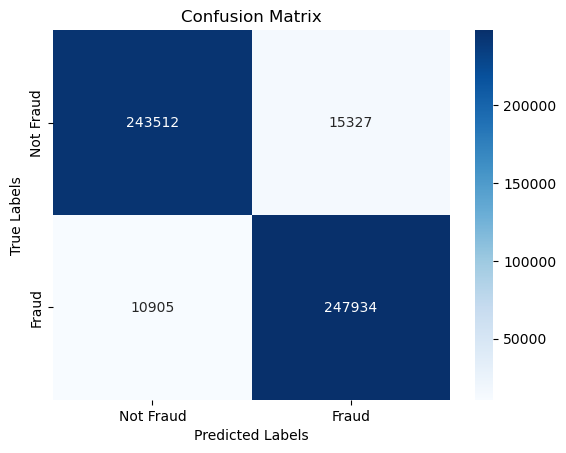

Cross-validated metrics:
AUC: 0.9855 ± 0.0016
Accuracy: 0.9493 ± 0.0058
Precision: 0.9423 ± 0.0170
Recall: 0.9579 ± 0.0151
F1 Score: 0.9498 ± 0.0055


In [10]:
# Convert to torch tensors
encoded_data_x = torch.tensor(encoded_data_x, dtype=torch.float)
data_y = torch.tensor(data_y, dtype=torch.float).unsqueeze(1)

# Create edge_index for PyG data object
unique_nodes = pd.Index(data['SENDER_ACCOUNT_ID'].append(data['RECEIVER_ACCOUNT_ID']).unique())
node_mapping = {node: i for i, node in enumerate(unique_nodes)}
data['SENDER_ID_REINDEX'] = data['SENDER_ACCOUNT_ID'].map(node_mapping)
data['RECEIVER_ID_REINDEX'] = data['RECEIVER_ACCOUNT_ID'].map(node_mapping)
edge_index = torch.tensor([data['SENDER_ID_REINDEX'].values, data['RECEIVER_ID_REINDEX'].values], dtype=torch.long)

# Set up device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate, activation_function):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

        if activation_function == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation_function == 'leaky_relu':
            self.activation = torch.nn.LeakyReLU()
        elif activation_function == 'elu':
            self.activation = torch.nn.ELU()
        elif activation_function == 'selu':
            self.activation = torch.nn.SELU()
        else:
            raise ValueError("Invalid activation function")

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def cross_val_score_gnn(model_class, data_x, data_y, edge_index, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_aucs, val_accuracies, val_precisions, val_recalls, val_f1s = [], [], [], [], []
    all_preds, all_labels = [], []

    # Ensure data_y is 1-dimensional
    data_y = data_y.squeeze()

    for train_idx, val_idx in skf.split(data_x, data_y):
        train_data = Data(x=torch.tensor(data_x[train_idx], dtype=torch.float), edge_index=edge_index, y=torch.tensor(data_y[train_idx], dtype=torch.float).unsqueeze(1))
        val_data = Data(x=torch.tensor(data_x[val_idx], dtype=torch.float), edge_index=edge_index, y=torch.tensor(data_y[val_idx], dtype=torch.float).unsqueeze(1))

        model = model_class(num_features=data_x.shape[1], hidden_dim=128, num_classes=1, 
                            dropout_rate=0.12123553484148883, activation_function='elu').to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.008383895739955304, weight_decay=1e-4)
        criterion = torch.nn.BCEWithLogitsLoss()

        train_loader = DataLoader([train_data], batch_size=64, shuffle=True)
        val_loader = DataLoader([val_data], batch_size=64, shuffle=False)

        best_val_loss = float('inf')
        patience_counter = 0
        early_stopping_patience = 10

        model.train()
        for epoch in range(100):
            for batch in train_loader:
                batch = batch.to(device)
                optimizer.zero_grad()
                out = model(batch)
                out = out.view(-1)
                loss = criterion(out, batch.y.view(-1))
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_out = model(val_data.to(device))
                val_out = val_out.view(-1)
                val_loss = criterion(val_out, val_data.y.view(-1))

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= early_stopping_patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break
            model.train()

        model.eval()
        with torch.no_grad():
            val_out = model(val_data.to(device))
            val_out = val_out.view(-1)
            val_preds = torch.sigmoid(val_out).round().cpu().numpy()
            val_labels = val_data.y.cpu().numpy()

            val_auc = roc_auc_score(val_labels, val_out.cpu().numpy())
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_precision = precision_score(val_labels, val_preds, zero_division=0)
            val_recall = recall_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds)

            val_aucs.append(val_auc)
            val_accuracies.append(val_accuracy)
            val_precisions.append(val_precision)
            val_recalls.append(val_recall)
            val_f1s.append(val_f1)
            
            all_preds.extend(val_preds)
            all_labels.extend(val_labels)

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'AUC': (np.mean(val_aucs), np.std(val_aucs)),
        'Accuracy': (np.mean(val_accuracies), np.std(val_accuracies)),
        'Precision': (np.mean(val_precisions), np.std(val_precisions)),
        'Recall': (np.mean(val_recalls), np.std(val_recalls)),
        'F1 Score': (np.mean(val_f1s), np.std(val_f1s))
    }

# Evaluate the model with cross-validation
metrics = cross_val_score_gnn(GNNModel, encoded_data_x.numpy(), data_y.numpy().squeeze(), edge_index)
print(f"Cross-validated metrics:")
for metric, values in metrics.items():
    mean, std = values
    print(f'{metric}: {mean:.4f} ± {std:.4f}')

## With resiudal blocks

In [11]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

data = pd.read_csv('processed_data.csv')

# Ensure TIMESTAMP is in datetime format
if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# Creating interaction features and temporal features
data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month

# Behavioral patterns
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

# Graph-based features
G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

# Prepare data for GNN model
features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

# Normalize features
scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

# Apply SMOTE
smote = SMOTE(random_state=42)
data_x, data_y = smote.fit_resample(data_x, data_y)

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        return out + residual

class ImprovedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(ImprovedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            ResidualBlock(256, 256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            ResidualBlock(128, 128),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            ResidualBlock(128, 128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            ResidualBlock(256, 256),
            nn.Linear(256, input_dim),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.dropout(x)
        x = self.decoder(x)
        return x

# Train the improved autoencoder
def train_improved_autoencoder(data_x, encoding_dim, num_epochs=100, learning_rate=0.001):
    input_dim = data_x.shape[1]
    autoencoder = ImprovedAutoencoder(input_dim, encoding_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    data_x_tensor = torch.tensor(data_x, dtype=torch.float).to(device)
    for epoch in range(num_epochs):
        autoencoder.train()
        optimizer.zero_grad()
        outputs = autoencoder(data_x_tensor)
        loss = criterion(outputs, data_x_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    encoded_data = autoencoder.encoder(data_x_tensor).detach().cpu().numpy()
    return encoded_data

# Encode the features using the improved autoencoder
encoding_dim = 64  # Adjust this dimension as needed
encoded_data_x = train_improved_autoencoder(data_x, encoding_dim)

Epoch [10/100], Loss: 0.3778
Epoch [20/100], Loss: 0.3469
Epoch [30/100], Loss: 0.3351
Epoch [40/100], Loss: 0.3297
Epoch [50/100], Loss: 0.3267
Epoch [60/100], Loss: 0.3246
Epoch [70/100], Loss: 0.3234
Epoch [80/100], Loss: 0.3224
Epoch [90/100], Loss: 0.3216
Epoch [100/100], Loss: 0.3211


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Early stopping at epoch 62


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Early stopping at epoch 84


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Early stopping at epoch 55


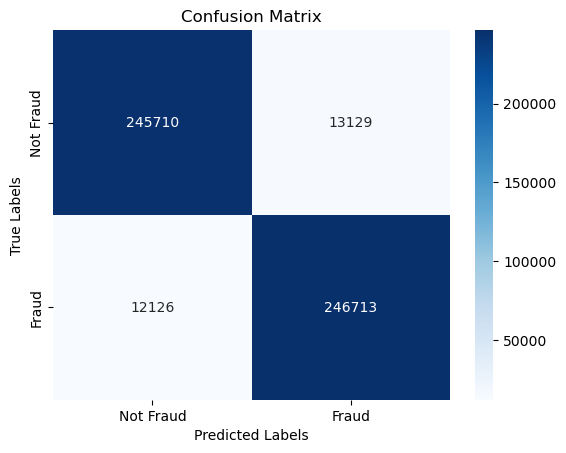

Cross-validated metrics:
AUC: 0.9853 ± 0.0033
Accuracy: 0.9512 ± 0.0070
Precision: 0.9496 ± 0.0081
Recall: 0.9532 ± 0.0188
F1 Score: 0.9512 ± 0.0075


In [13]:
# Convert to torch tensors
encoded_data_x = torch.tensor(encoded_data_x, dtype=torch.float)
data_y = torch.tensor(data_y, dtype=torch.float).unsqueeze(1)

# Create edge_index for PyG data object
unique_nodes = pd.Index(data['SENDER_ACCOUNT_ID'].append(data['RECEIVER_ACCOUNT_ID']).unique())
node_mapping = {node: i for i, node in enumerate(unique_nodes)}
data['SENDER_ID_REINDEX'] = data['SENDER_ACCOUNT_ID'].map(node_mapping)
data['RECEIVER_ID_REINDEX'] = data['RECEIVER_ACCOUNT_ID'].map(node_mapping)
edge_index = torch.tensor([data['SENDER_ID_REINDEX'].values, data['RECEIVER_ID_REINDEX'].values], dtype=torch.long)    

# Set up device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate, activation_function):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

        if activation_function == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation_function == 'leaky_relu':
            self.activation = torch.nn.LeakyReLU()
        elif activation_function == 'elu':
            self.activation = torch.nn.ELU()
        elif activation_function == 'selu':
            self.activation = torch.nn.SELU()
        else:
            raise ValueError("Invalid activation function")

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def cross_val_score_gnn(model_class, data_x, data_y, edge_index, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_aucs, val_accuracies, val_precisions, val_recalls, val_f1s = [], [], [], [], []
    all_preds, all_labels = [], []

    # Ensure data_y is 1-dimensional
    data_y = data_y.squeeze()

    for train_idx, val_idx in skf.split(data_x, data_y):
        train_data = Data(x=torch.tensor(data_x[train_idx], dtype=torch.float), edge_index=edge_index, y=torch.tensor(data_y[train_idx], dtype=torch.float).unsqueeze(1))
        val_data = Data(x=torch.tensor(data_x[val_idx], dtype=torch.float), edge_index=edge_index, y=torch.tensor(data_y[val_idx], dtype=torch.float).unsqueeze(1))

        model = model_class(num_features=data_x.shape[1], hidden_dim=128, num_classes=1, 
                            dropout_rate=0.12123553484148883, activation_function='elu').to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.008383895739955304, weight_decay=1e-4)
        criterion = torch.nn.BCEWithLogitsLoss()

        train_loader = DataLoader([train_data], batch_size=64, shuffle=True)
        val_loader = DataLoader([val_data], batch_size=64, shuffle=False)

        best_val_loss = float('inf')
        patience_counter = 0
        early_stopping_patience = 10

        model.train()
        for epoch in range(100):
            for batch in train_loader:
                batch = batch.to(device)
                optimizer.zero_grad()
                out = model(batch)
                out = out.view(-1)
                loss = criterion(out, batch.y.view(-1))
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_out = model(val_data.to(device))
                val_out = val_out.view(-1)
                val_loss = criterion(val_out, val_data.y.view(-1))

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= early_stopping_patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break
            model.train()

        model.eval()
        with torch.no_grad():
            val_out = model(val_data.to(device))
            val_out = val_out.view(-1)
            val_preds = torch.sigmoid(val_out).round().cpu().numpy()
            val_labels = val_data.y.cpu().numpy()

            val_auc = roc_auc_score(val_labels, val_out.cpu().numpy())
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_precision = precision_score(val_labels, val_preds, zero_division=0)
            val_recall = recall_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds)

            val_aucs.append(val_auc)
            val_accuracies.append(val_accuracy)
            val_precisions.append(val_precision)
            val_recalls.append(val_recall)
            val_f1s.append(val_f1)
            
            all_preds.extend(val_preds)
            all_labels.extend(val_labels)

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'AUC': (np.mean(val_aucs), np.std(val_aucs)),
        'Accuracy': (np.mean(val_accuracies), np.std(val_accuracies)),
        'Precision': (np.mean(val_precisions), np.std(val_precisions)),
        'Recall': (np.mean(val_recalls), np.std(val_recalls)),
        'F1 Score': (np.mean(val_f1s), np.std(val_f1s))
    }

# Evaluate the model with cross-validation
metrics = cross_val_score_gnn(GNNModel, encoded_data_x.numpy(), data_y.numpy().squeeze(), edge_index)
print(f"Cross-validated metrics:")
for metric, values in metrics.items():
    mean, std = values
    print(f'{metric}: {mean:.4f} ± {std:.4f}')

## Without residual blocks

In [18]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

data = pd.read_csv('processed_data.csv')

# Ensure TIMESTAMP is in datetime format
if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# Creating interaction features and temporal features
data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month

# Behavioral patterns
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

# Graph-based features
G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

# Prepare data for GNN model
features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

# Normalize features
scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

# Apply SMOTE
smote = SMOTE(random_state=42)
data_x, data_y = smote.fit_resample(data_x, data_y)

In [19]:
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader

class ImprovedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(ImprovedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, input_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Train the improved autoencoder
def train_improved_autoencoder(data_x, encoding_dim, num_epochs=100, learning_rate=0.001):
    input_dim = data_x.shape[1]
    autoencoder = ImprovedAutoencoder(input_dim, encoding_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    data_x_tensor = torch.tensor(data_x, dtype=torch.float).to(device)
    for epoch in range(num_epochs):
        autoencoder.train()
        optimizer.zero_grad()
        outputs = autoencoder(data_x_tensor)
        loss = criterion(outputs, data_x_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    encoded_data = autoencoder.encoder(data_x_tensor).detach().cpu().numpy()
    return encoded_data

# Encode the features using the improved autoencoder
encoding_dim = 64  # Adjust this dimension as needed
encoded_data_x = train_improved_autoencoder(data_x, encoding_dim)

Epoch [10/100], Loss: 0.3923
Epoch [20/100], Loss: 0.3572
Epoch [30/100], Loss: 0.3450
Epoch [40/100], Loss: 0.3396
Epoch [50/100], Loss: 0.3364
Epoch [60/100], Loss: 0.3340
Epoch [70/100], Loss: 0.3321
Epoch [80/100], Loss: 0.3308
Epoch [90/100], Loss: 0.3295
Epoch [100/100], Loss: 0.3283


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
Epoch 10/10: 100%|████████████████████████████████| 1/1 [00:06<00:00,  6.62s/it]


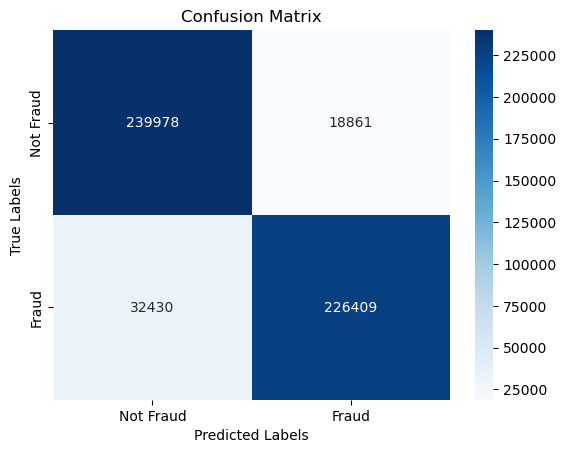

Cross-validated metrics:
AUC: 0.9620 ± 0.0008
Accuracy: 0.9009 ± 0.0071
Precision: 0.9235 ± 0.0106
Recall: 0.8747 ± 0.0271
F1 Score: 0.8981 ± 0.0094


In [21]:
from torch_geometric.loader import DataLoader as PyGDataLoader
from tqdm import tqdm

# Convert to torch tensors
encoded_data_x = torch.tensor(encoded_data_x, dtype=torch.float)
data_y = torch.tensor(data_y, dtype=torch.float).unsqueeze(1)

# Create edge_index for PyG data object
unique_nodes = pd.Index(data['SENDER_ACCOUNT_ID'].append(data['RECEIVER_ACCOUNT_ID']).unique())
node_mapping = {node: i for i, node in enumerate(unique_nodes)}
data['SENDER_ID_REINDEX'] = data['SENDER_ACCOUNT_ID'].map(node_mapping)
data['RECEIVER_ID_REINDEX'] = data['RECEIVER_ACCOUNT_ID'].map(node_mapping)
edge_index = torch.tensor([data['SENDER_ID_REINDEX'].values, data['RECEIVER_ID_REINDEX'].values], dtype=torch.long)

# Set up device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate, activation_function):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

        if activation_function == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation_function == 'leaky_relu':
            self.activation = torch.nn.LeakyReLU()
        elif activation_function == 'elu':
            self.activation = torch.nn.ELU()
        elif activation_function == 'selu':
            self.activation = torch.nn.SELU()
        else:
            raise ValueError("Invalid activation function")

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def cross_val_score_gnn(model_class, data_x, data_y, edge_index, n_splits=5, epochs=10, batch_size=64):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_aucs, val_accuracies, val_precisions, val_recalls, val_f1s = [], [], [], [], []
    all_preds, all_labels = [], []

    # Ensure data_y is 1-dimensional
    data_y = data_y.squeeze()

    for train_idx, val_idx in skf.split(data_x, data_y):
        train_data = Data(x=torch.tensor(data_x[train_idx], dtype=torch.float), edge_index=edge_index, y=torch.tensor(data_y[train_idx], dtype=torch.float).unsqueeze(1))
        val_data = Data(x=torch.tensor(data_x[val_idx], dtype=torch.float), edge_index=edge_index, y=torch.tensor(data_y[val_idx], dtype=torch.float).unsqueeze(1))

        model = model_class(num_features=data_x.shape[1], hidden_dim=128, num_classes=1, 
                            dropout_rate=0.12123553484148883, activation_function='elu').to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.008383895739955304, weight_decay=1e-4)
        criterion = torch.nn.BCEWithLogitsLoss()

        train_loader = PyGDataLoader([train_data], batch_size=batch_size, shuffle=True)
        val_loader = PyGDataLoader([val_data], batch_size=batch_size, shuffle=False)

        best_val_loss = float('inf')
        patience_counter = 0
        early_stopping_patience = 3

        model.train()
        for epoch in range(epochs):
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                batch = batch.to(device)
                optimizer.zero_grad()
                out = model(batch)
                out = out.view(-1)
                loss = criterion(out, batch.y.view(-1))
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_out = model(val_data.to(device))
                val_out = val_out.view(-1)
                val_loss = criterion(val_out, val_data.y.view(-1))

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= early_stopping_patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break
            model.train()

        model.eval()
        with torch.no_grad():
            val_out = model(val_data.to(device))
            val_out = val_out.view(-1)
            val_preds = torch.sigmoid(val_out).round().cpu().numpy()
            val_labels = val_data.y.cpu().numpy()

            val_auc = roc_auc_score(val_labels, val_out.cpu().numpy())
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_precision = precision_score(val_labels, val_preds, zero_division=0)
            val_recall = recall_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds)

            val_aucs.append(val_auc)
            val_accuracies.append(val_accuracy)
            val_precisions.append(val_precision)
            val_recalls.append(val_recall)
            val_f1s.append(val_f1)
            
            all_preds.extend(val_preds)
            all_labels.extend(val_labels)

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'AUC': (np.mean(val_aucs), np.std(val_aucs)),
        'Accuracy': (np.mean(val_accuracies), np.std(val_accuracies)),
        'Precision': (np.mean(val_precisions), np.std(val_precisions)),
        'Recall': (np.mean(val_recalls), np.std(val_recalls)),
        'F1 Score': (np.mean(val_f1s), np.std(val_f1s))
    }

# Evaluate the model with cross-validation
metrics = cross_val_score_gnn(GNNModel, encoded_data_x.numpy(), data_y.numpy().squeeze(), edge_index, epochs=10, batch_size=64)
print(f"Cross-validated metrics:")
for metric, values in metrics.items():
    mean, std = values
    print(f'{metric}: {mean:.4f} ± {std:.4f}')

## Denoising

In [22]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

data = pd.read_csv('processed_data.csv')

# Ensure TIMESTAMP is in datetime format
if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# Creating interaction features and temporal features
data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month

# Behavioral patterns
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

# Graph-based features
G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

# Prepare data for GNN model
features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

# Normalize features
scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

# Apply SMOTE
smote = SMOTE(random_state=42)
data_x, data_y = smote.fit_resample(data_x, data_y)

In [23]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, input_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Train the denoising autoencoder
def train_denoising_autoencoder(data_x, encoding_dim, noise_factor=0.5, num_epochs=100, learning_rate=0.001):
    input_dim = data_x.shape[1]
    autoencoder = DenoisingAutoencoder(input_dim, encoding_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    data_x_tensor = torch.tensor(data_x, dtype=torch.float).to(device)
    for epoch in range(num_epochs):
        autoencoder.train()
        noisy_data = data_x_tensor + noise_factor * torch.randn_like(data_x_tensor)
        noisy_data = torch.clamp(noisy_data, 0., 1.)
        optimizer.zero_grad()
        outputs = autoencoder(noisy_data)
        loss = criterion(outputs, data_x_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    encoded_data = autoencoder.encoder(data_x_tensor).detach().cpu().numpy()
    return encoded_data

# Encode the features using the denoising autoencoder
encoding_dim = 64  # Adjust this dimension as needed
encoded_data_x = train_denoising_autoencoder(data_x, encoding_dim)

Epoch [10/100], Loss: 0.5753
Epoch [20/100], Loss: 0.5352
Epoch [30/100], Loss: 0.5210
Epoch [40/100], Loss: 0.5140
Epoch [50/100], Loss: 0.5082
Epoch [60/100], Loss: 0.5049
Epoch [70/100], Loss: 0.5001
Epoch [80/100], Loss: 0.4997
Epoch [90/100], Loss: 0.4986
Epoch [100/100], Loss: 0.4954


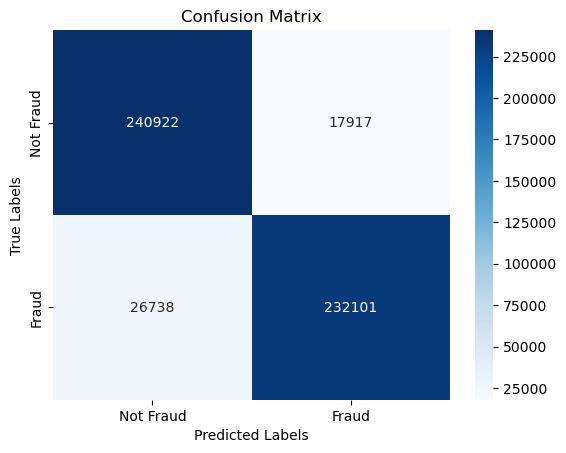

Cross-validated metrics:
AUC: 0.9696 ± 0.0003
Accuracy: 0.9137 ± 0.0009
Precision: 0.9283 ± 0.0008
Recall: 0.8967 ± 0.0013
F1 Score: 0.9122 ± 0.0010


In [24]:
# Convert to torch tensors
encoded_data_x = torch.tensor(encoded_data_x, dtype=torch.float)
data_y = torch.tensor(data_y, dtype=torch.float).unsqueeze(1)

# Create edge_index for PyG data object
unique_nodes = pd.Index(data['SENDER_ACCOUNT_ID'].append(data['RECEIVER_ACCOUNT_ID']).unique())
node_mapping = {node: i for i, node in enumerate(unique_nodes)}
data['SENDER_ID_REINDEX'] = data['SENDER_ACCOUNT_ID'].map(node_mapping)
data['RECEIVER_ID_REINDEX'] = data['RECEIVER_ACCOUNT_ID'].map(node_mapping)
edge_index = torch.tensor([data['SENDER_ID_REINDEX'].values, data['RECEIVER_ID_REINDEX'].values], dtype=torch.long)

# Set up device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate, activation_function):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

        if activation_function == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation_function == 'leaky_relu':
            self.activation = torch.nn.LeakyReLU()
        elif activation_function == 'elu':
            self.activation = torch.nn.ELU()
        elif activation_function == 'selu':
            self.activation = torch.nn.SELU()
        else:
            raise ValueError("Invalid activation function")

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def cross_val_score_gnn(model_class, data_x, data_y, edge_index, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_aucs, val_accuracies, val_precisions, val_recalls, val_f1s = [], [], [], [], []
    all_preds, all_labels = [], []

    # Ensure data_y is 1-dimensional
    data_y = data_y.squeeze()

    for train_idx, val_idx in skf.split(data_x, data_y):
        train_data = Data(x=torch.tensor(data_x[train_idx], dtype=torch.float), edge_index=edge_index, y=torch.tensor(data_y[train_idx], dtype=torch.float).unsqueeze(1))
        val_data = Data(x=torch.tensor(data_x[val_idx], dtype=torch.float), edge_index=edge_index, y=torch.tensor(data_y[val_idx], dtype=torch.float).unsqueeze(1))

        model = model_class(num_features=data_x.shape[1], hidden_dim=128, num_classes=1, 
                            dropout_rate=0.12123553484148883, activation_function='elu').to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.008383895739955304, weight_decay=1e-4)
        criterion = torch.nn.BCEWithLogitsLoss()

        train_loader = PyGDataLoader([train_data], batch_size=64, shuffle=True)
        val_loader = PyGDataLoader([val_data], batch_size=64, shuffle=False)

        best_val_loss = float('inf')
        patience_counter = 0
        early_stopping_patience = 10

        model.train()
        for epoch in range(100):
            for batch in train_loader:
                batch = batch.to(device)
                optimizer.zero_grad()
                out = model(batch)
                out = out.view(-1)
                loss = criterion(out, batch.y.view(-1))
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_out = model(val_data.to(device))
                val_out = val_out.view(-1)
                val_loss = criterion(val_out, val_data.y.view(-1))

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= early_stopping_patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break
            model.train()

        model.eval()
        with torch.no_grad():
            val_out = model(val_data.to(device))
            val_out = val_out.view(-1)
            val_preds = torch.sigmoid(val_out).round().cpu().numpy()
            val_labels = val_data.y.cpu().numpy()

            val_auc = roc_auc_score(val_labels, val_out.cpu().numpy())
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_precision = precision_score(val_labels, val_preds, zero_division=0)
            val_recall = recall_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds)

            val_aucs.append(val_auc)
            val_accuracies.append(val_accuracy)
            val_precisions.append(val_precision)
            val_recalls.append(val_recall)
            val_f1s.append(val_f1)
            
            all_preds.extend(val_preds)
            all_labels.extend(val_labels)

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'AUC': (np.mean(val_aucs), np.std(val_aucs)),
        'Accuracy': (np.mean(val_accuracies), np.std(val_accuracies)),
        'Precision': (np.mean(val_precisions), np.std(val_precisions)),
        'Recall': (np.mean(val_recalls), np.std(val_recalls)),
        'F1 Score': (np.mean(val_f1s), np.std(val_f1s))
    }

# Evaluate the model with cross-validation
metrics = cross_val_score_gnn(GNNModel, encoded_data_x.numpy(), data_y.numpy().squeeze(), edge_index)
print(f"Cross-validated metrics:")
for metric, values in metrics.items():
    mean, std = values
    print(f'{metric}: {mean:.4f} ± {std:.4f}')

## Variational Autoencoder

In [25]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

data = pd.read_csv('processed_data.csv')

# Ensure TIMESTAMP is in datetime format
if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# Creating interaction features and temporal features
data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month

# Behavioral patterns
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

# Graph-based features
G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

# Prepare data for GNN model
features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

# Normalize features
scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

# Apply SMOTE
smote = SMOTE(random_state=42)
data_x, data_y = smote.fit_resample(data_x, data_y)

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch_geometric.loader import DataLoader as PyGDataLoader
from tqdm import tqdm
import optuna
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# Set up device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class VAE(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, encoding_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(encoding_dim, encoding_dim)
        self.fc_logvar = nn.Linear(encoding_dim, encoding_dim)
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, input_dim),
            nn.ReLU()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train_vae(data_x, encoding_dim, num_epochs=100, learning_rate=0.001):
    input_dim = data_x.shape[1]
    vae = VAE(input_dim, encoding_dim).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    data_x_tensor = torch.tensor(data_x, dtype=torch.float).to(device)
    for epoch in range(num_epochs):
        vae.train()
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(data_x_tensor)
        loss = vae_loss(recon_x, data_x_tensor, mu, logvar)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    encoded_data = vae.encode(data_x_tensor)[0].detach().cpu().numpy()
    return encoded_data

# Encode the features using the VAE
encoding_dim = 64  # Adjust this dimension as needed
encoded_data_x = train_vae(data_x, encoding_dim)

Epoch [10/100], Loss: 9938398.0000
Epoch [20/100], Loss: 5062203.0000
Epoch [30/100], Loss: 4509481.0000
Epoch [40/100], Loss: 4339574.5000
Epoch [50/100], Loss: 4051668.0000
Epoch [60/100], Loss: 3924628.0000
Epoch [70/100], Loss: 3850797.7500
Epoch [80/100], Loss: 3784427.2500
Epoch [90/100], Loss: 3730505.0000
Epoch [100/100], Loss: 3697768.5000


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
Epoch 1/10:   0%|                                         | 0/1 [00:00<?, ?it/s]/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Epoch 10/10: 100%|████████████████████████████████| 1/1 [00:05<00:00,  5.72s/it]
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but C

Early stopping at epoch 9


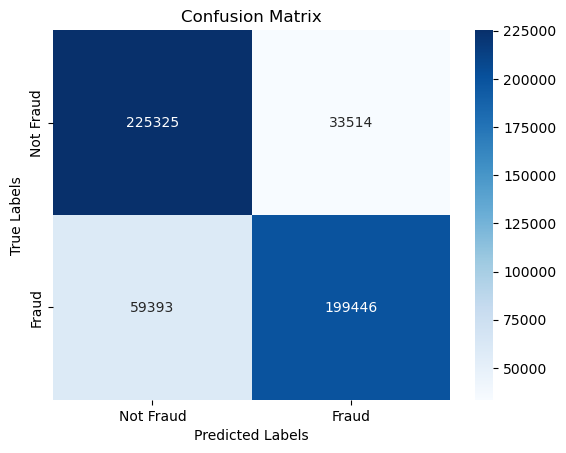

Cross-validated metrics:
AUC: 0.9012 ± 0.0050
Accuracy: 0.8205 ± 0.0089
Precision: 0.8564 ± 0.0056
Recall: 0.7705 ± 0.0274
F1 Score: 0.8108 ± 0.0132


In [27]:
# Convert to torch tensors
encoded_data_x = torch.tensor(encoded_data_x, dtype=torch.float)
data_y = torch.tensor(data_y, dtype=torch.float).unsqueeze(1)

# Create edge_index for PyG data object
unique_nodes = pd.Index(data['SENDER_ACCOUNT_ID'].append(data['RECEIVER_ACCOUNT_ID']).unique())
node_mapping = {node: i for i, node in enumerate(unique_nodes)}
data['SENDER_ID_REINDEX'] = data['SENDER_ACCOUNT_ID'].map(node_mapping)
data['RECEIVER_ID_REINDEX'] = data['RECEIVER_ACCOUNT_ID'].map(node_mapping)
edge_index = torch.tensor([data['SENDER_ID_REINDEX'].values, data['RECEIVER_ID_REINDEX'].values], dtype=torch.long)

# Set up device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate, activation_function):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

        if activation_function == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation_function == 'leaky_relu':
            self.activation = torch.nn.LeakyReLU()
        elif activation_function == 'elu':
            self.activation = torch.nn.ELU()
        elif activation_function == 'selu':
            self.activation = torch.nn.SELU()
        else:
            raise ValueError("Invalid activation function")

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def cross_val_score_gnn(model_class, data_x, data_y, edge_index, n_splits=5, epochs=10, batch_size=64):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_aucs, val_accuracies, val_precisions, val_recalls, val_f1s = [], [], [], [], []
    all_preds, all_labels = [], []

    # Ensure data_y is 1-dimensional
    data_y = data_y.squeeze()

    for train_idx, val_idx in skf.split(data_x, data_y):
        train_data = Data(x=torch.tensor(data_x[train_idx], dtype=torch.float), edge_index=edge_index, y=torch.tensor(data_y[train_idx], dtype=torch.float).unsqueeze(1))
        val_data = Data(x=torch.tensor(data_x[val_idx], dtype=torch.float), edge_index=edge_index, y=torch.tensor(data_y[val_idx], dtype=torch.float).unsqueeze(1))

        model = model_class(num_features=data_x.shape[1], hidden_dim=128, num_classes=1, 
                            dropout_rate=0.12123553484148883, activation_function='elu').to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.008383895739955304, weight_decay=1e-4)
        criterion = torch.nn.BCEWithLogitsLoss()

        train_loader = PyGDataLoader([train_data], batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = PyGDataLoader([val_data], batch_size=batch_size, shuffle=False, num_workers=4)

        best_val_loss = float('inf')
        patience_counter = 0
        early_stopping_patience = 3

        model.train()
        scaler = torch.cuda.amp.GradScaler()

        for epoch in range(epochs):
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                batch = batch.to(device)
                optimizer.zero_grad()
                with torch.cuda.amp.autocast():
                    out = model(batch)
                    out = out.view(-1)
                    loss = criterion(out, batch.y.view(-1))
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            model.eval()
            with torch.no_grad():
                val_out = model(val_data.to(device))
                val_out = val_out.view(-1)
                val_loss = criterion(val_out, val_data.y.view(-1))

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= early_stopping_patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break
            model.train()

        model.eval()
        with torch.no_grad():
            val_out = model(val_data.to(device))
            val_out = val_out.view(-1)
            val_preds = torch.sigmoid(val_out).round().cpu().numpy()
            val_labels = val_data.y.cpu().numpy()

            val_auc = roc_auc_score(val_labels, val_out.cpu().numpy())
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_precision = precision_score(val_labels, val_preds, zero_division=0)
            val_recall = recall_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds)

            val_aucs.append(val_auc)
            val_accuracies.append(val_accuracy)
            val_precisions.append(val_precision)
            val_recalls.append(val_recall)
            val_f1s.append(val_f1)
            
            all_preds.extend(val_preds)
            all_labels.extend(val_labels)

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'AUC': (np.mean(val_aucs), np.std(val_aucs)),
        'Accuracy': (np.mean(val_accuracies), np.std(val_accuracies)),
        'Precision': (np.mean(val_precisions), np.std(val_precisions)),
        'Recall': (np.mean(val_recalls), np.std(val_recalls)),
        'F1 Score': (np.mean(val_f1s), np.std(val_f1s))
    }

# Evaluate the model with cross-validation
metrics = cross_val_score_gnn(GNNModel, encoded_data_x.numpy(), data_y.numpy().squeeze(), edge_index, epochs=10, batch_size=64)
print(f"Cross-validated metrics:")
for metric, values in metrics.items():
    mean, std = values
    print(f'{metric}: {mean:.4f} ± {std:.4f}')

## Optuna

In [2]:
import sys
print(sys.version)

3.7.13 (default, Mar 28 2022, 07:24:34) 
[Clang 12.0.0 ]


In [13]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader as PyGDataLoader, Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from tqdm import tqdm

# Load data
data = pd.read_csv('processed_data.csv')

# Ensure TIMESTAMP is in datetime format
if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# Creating interaction features and temporal features
data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month

# Behavioral patterns
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

# Graph-based features
G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

# Prepare data for GNN model
features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

# Normalize features
scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

# Apply SMOTE
smote = SMOTE(random_state=42)
data_x, data_y = smote.fit_resample(data_x, data_y)

# Convert to torch tensors
data_x = torch.tensor(data_x, dtype=torch.float)
data_y = torch.tensor(data_y, dtype=torch.float).unsqueeze(1)

# Create edge_index for PyG data object
unique_nodes = pd.Index(data['SENDER_ACCOUNT_ID'].append(data['RECEIVER_ACCOUNT_ID']).unique())
node_mapping = {node: i for i, node in enumerate(unique_nodes)}
data['SENDER_ID_REINDEX'] = data['SENDER_ACCOUNT_ID'].map(node_mapping)
data['RECEIVER_ID_REINDEX'] = data['RECEIVER_ACCOUNT_ID'].map(node_mapping)

# Print the size of the unique nodes and the edge index
print(f"Unique nodes: {len(unique_nodes)}")
print(f"Edge index max value: {max(data['SENDER_ID_REINDEX'].max(), data['RECEIVER_ID_REINDEX'].max())}")

edge_index = torch.tensor([data['SENDER_ID_REINDEX'].values, data['RECEIVER_ID_REINDEX'].values], dtype=torch.long)

Unique nodes: 13149
Edge index max value: 13148


In [25]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import optuna

data = pd.read_csv('processed_data.csv')

if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month

data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

smote = SMOTE(random_state=42)
data_x, data_y = smote.fit_resample(data_x, data_y)

In [27]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        return out + residual

class ImprovedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(ImprovedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            ResidualBlock(256, 256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            ResidualBlock(128, 128),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            ResidualBlock(128, 128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            ResidualBlock(256, 256),
            nn.Linear(256, input_dim),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.dropout(x)
        x = self.decoder(x)
        return x

def train_improved_autoencoder(data_x, encoding_dim, num_epochs=50, learning_rate=0.001):
    input_dim = data_x.shape[1]
    autoencoder = ImprovedAutoencoder(input_dim, encoding_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    data_x_tensor = torch.tensor(data_x, dtype=torch.float).to(device)
    for epoch in range(num_epochs):
        autoencoder.train()
        optimizer.zero_grad()
        outputs = autoencoder(data_x_tensor)
        loss = criterion(outputs, data_x_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    encoded_data = autoencoder.encoder(data_x_tensor).detach().cpu().numpy()
    return encoded_data

encoding_dim = 64
encoded_data_x = train_improved_autoencoder(data_x, encoding_dim)
encoded_data_x = torch.tensor(encoded_data_x, dtype=torch.float)
data_y = torch.tensor(data_y, dtype=torch.float).unsqueeze(1)

unique_nodes = pd.Index(data['SENDER_ACCOUNT_ID'].append(data['RECEIVER_ACCOUNT_ID']).unique())
node_mapping = {node: i for i, node in enumerate(unique_nodes)}
data['SENDER_ID_REINDEX'] = data['SENDER_ACCOUNT_ID'].map(node_mapping)
data['RECEIVER_ID_REINDEX'] = data['RECEIVER_ACCOUNT_ID'].map(node_mapping)
edge_index = torch.tensor([data['SENDER_ID_REINDEX'].values, data['RECEIVER_ID_REINDEX'].values], dtype=torch.long)

Epoch [10/50], Loss: 0.3780
Epoch [20/50], Loss: 0.3423
Epoch [30/50], Loss: 0.3321
Epoch [40/50], Loss: 0.3273
Epoch [50/50], Loss: 0.3246


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate, activation_function):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

        if activation_function == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation_function == 'leaky_relu':
            self.activation = torch.nn.LeakyReLU()
        elif activation_function == 'elu':
            self.activation = torch.nn.ELU()
        elif activation_function == 'selu':
            self.activation = torch.nn.SELU()
        else:
            raise ValueError("Invalid activation function")

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'leaky_relu', 'elu', 'selu'])

    model = GNNModel(num_features=encoded_data_x.shape[1], hidden_dim=hidden_dim, num_classes=1, dropout_rate=dropout_rate, activation_function=activation_function).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = torch.nn.BCEWithLogitsLoss()

    train_loader = DataLoader([Data(x=encoded_data_x, edge_index=edge_index, y=data_y)], batch_size=64, shuffle=True)

    best_auc = 0
    patience = 10
    trigger_times = 0

    for epoch in range(50):  # Reduce the number of epochs for quicker tuning
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            out = out.view(-1)
            loss = criterion(out, data.y.view(-1))
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            out_test = model(Data(x=encoded_data_x, edge_index=edge_index, y=data_y).to(device))
            out_test = out_test.view(-1)
            auc = roc_auc_score(data_y.cpu().numpy(), out_test.cpu().numpy())
            if auc > best_auc:
                best_auc = auc
                trigger_times = 0
            else:
                trigger_times += 1
            if trigger_times >= patience:
                break
        model.train()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        out_test = model(Data(x=encoded_data_x, edge_index=edge_index, y=data_y).to(device))
        out_test = out_test.view(-1)
        preds_test = torch.sigmoid(out_test).round()
        accuracy_test = accuracy_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
        precision_test = precision_score(data_y.cpu().numpy(), preds_test.cpu().numpy(), zero_division=0)
        recall_test = recall_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
        f1_test = f1_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
        roc_auc_test = roc_auc_score(data_y.cpu().numpy(), out_test.cpu().numpy())

    print(f'Trial {trial.number}:')
    print(f'  AUC: {auc:.4f}')
    print(f'  Accuracy: {accuracy_test:.4f}')
    print(f'  Precision: {precision_test:.4f}')
    print(f'  Recall: {recall_test:.4f}')
    print(f'  F1 Score: {f1_test:.4f}')
    print(f'  ROC AUC: {roc_auc_test:.4f}')

    return best_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Reduce the number of trials for quicker results

best_trial = study.best_trial
print(f'Best trial:')
print(f'  AUC: {best_trial.value}')
print(f'  Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

[I 2024-07-08 08:56:44,256] A new study created in memory with name: no-name-acfba8db-8b3a-4e72-ad00-25466b77b2ba
[I 2024-07-08 09:02:59,001] Trial 0 finished with value: 0.9202971847929224 and parameters: {'hidden_dim': 111, 'dropout_rate': 0.4409939348025391, 'lr': 0.00021567388560983467, 'activation_function': 'elu'}. Best is trial 0 with value: 0.9202971847929224.


Trial 0:
  AUC: 0.9203
  Accuracy: 0.8260
  Precision: 0.9127
  Recall: 0.7210
  F1 Score: 0.8056
  ROC AUC: 0.9203


[I 2024-07-08 09:05:51,556] Trial 1 finished with value: 0.7766983430272959 and parameters: {'hidden_dim': 62, 'dropout_rate': 0.14591845061713504, 'lr': 1.1855067991444374e-05, 'activation_function': 'relu'}. Best is trial 0 with value: 0.9202971847929224.


Trial 1:
  AUC: 0.7767
  Accuracy: 0.4966
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.7767


[I 2024-07-08 09:07:15,007] Trial 2 finished with value: 0.9275992356293619 and parameters: {'hidden_dim': 79, 'dropout_rate': 0.12291446960781811, 'lr': 0.0021747883376782664, 'activation_function': 'leaky_relu'}. Best is trial 2 with value: 0.9275992356293619.


Trial 2:
  AUC: 0.9218
  Accuracy: 0.8489
  Precision: 0.9101
  Recall: 0.7743
  F1 Score: 0.8368
  ROC AUC: 0.9218


[I 2024-07-08 09:09:43,386] Trial 3 finished with value: 0.2553290878323483 and parameters: {'hidden_dim': 52, 'dropout_rate': 0.15749776531053078, 'lr': 2.381775324302167e-05, 'activation_function': 'relu'}. Best is trial 2 with value: 0.9275992356293619.


Trial 3:
  AUC: 0.2553
  Accuracy: 0.5152
  Precision: 0.5078
  Recall: 0.9908
  F1 Score: 0.6715
  ROC AUC: 0.2553


[I 2024-07-08 09:13:48,675] Trial 4 finished with value: 0.8155654042771434 and parameters: {'hidden_dim': 75, 'dropout_rate': 0.22718524963630957, 'lr': 8.108748165419212e-05, 'activation_function': 'leaky_relu'}. Best is trial 2 with value: 0.9275992356293619.


Trial 4:
  AUC: 0.8156
  Accuracy: 0.6935
  Precision: 0.9785
  Recall: 0.3958
  F1 Score: 0.5636
  ROC AUC: 0.8156


[I 2024-07-08 09:18:05,629] Trial 5 finished with value: 0.9771464550460587 and parameters: {'hidden_dim': 84, 'dropout_rate': 0.3813152062245837, 'lr': 0.0026625610532156705, 'activation_function': 'relu'}. Best is trial 5 with value: 0.9771464550460587.


Trial 5:
  AUC: 0.9771
  Accuracy: 0.9304
  Precision: 0.9220
  Recall: 0.9403
  F1 Score: 0.9311
  ROC AUC: 0.9771


[I 2024-07-08 09:21:08,327] Trial 6 finished with value: 0.6399627185093337 and parameters: {'hidden_dim': 62, 'dropout_rate': 0.44627394646347107, 'lr': 1.496220877539602e-05, 'activation_function': 'leaky_relu'}. Best is trial 5 with value: 0.9771464550460587.


Trial 6:
  AUC: 0.6400
  Accuracy: 0.5994
  Precision: 0.5953
  Recall: 0.6209
  F1 Score: 0.6079
  ROC AUC: 0.6400


[I 2024-07-08 09:23:50,259] Trial 7 finished with value: 0.7333708462475163 and parameters: {'hidden_dim': 57, 'dropout_rate': 0.3936526160325914, 'lr': 2.297561764404943e-05, 'activation_function': 'relu'}. Best is trial 5 with value: 0.9771464550460587.


Trial 7:
  AUC: 0.7334
  Accuracy: 0.6815
  Precision: 0.6983
  Recall: 0.6390
  F1 Score: 0.6673
  ROC AUC: 0.7334


[I 2024-07-08 09:26:56,679] Trial 8 finished with value: 0.652578579551409 and parameters: {'hidden_dim': 63, 'dropout_rate': 0.28293901024018436, 'lr': 4.862309884487486e-05, 'activation_function': 'leaky_relu'}. Best is trial 5 with value: 0.9771464550460587.


Trial 8:
  AUC: 0.6526
  Accuracy: 0.4833
  Precision: 0.0630
  Recall: 0.0024
  F1 Score: 0.0046
  ROC AUC: 0.6526


[I 2024-07-08 09:32:26,464] Trial 9 finished with value: 0.9401084624483805 and parameters: {'hidden_dim': 89, 'dropout_rate': 0.4225609874059395, 'lr': 0.0007088762810083267, 'activation_function': 'leaky_relu'}. Best is trial 5 with value: 0.9771464550460587.


Trial 9:
  AUC: 0.9401
  Accuracy: 0.8603
  Precision: 0.9157
  Recall: 0.7937
  F1 Score: 0.8504
  ROC AUC: 0.9401


[I 2024-07-08 09:39:56,349] Trial 10 finished with value: 0.979236628778256 and parameters: {'hidden_dim': 116, 'dropout_rate': 0.3483679016627425, 'lr': 0.009726062877009006, 'activation_function': 'selu'}. Best is trial 10 with value: 0.979236628778256.


Trial 10:
  AUC: 0.9792
  Accuracy: 0.9336
  Precision: 0.9214
  Recall: 0.9481
  F1 Score: 0.9346
  ROC AUC: 0.9792


[I 2024-07-08 09:47:54,404] Trial 11 finished with value: 0.9764362878285551 and parameters: {'hidden_dim': 125, 'dropout_rate': 0.3428030037733491, 'lr': 0.009618777436788389, 'activation_function': 'selu'}. Best is trial 10 with value: 0.979236628778256.


Trial 11:
  AUC: 0.9764
  Accuracy: 0.9263
  Precision: 0.9078
  Recall: 0.9489
  F1 Score: 0.9279
  ROC AUC: 0.9764


[I 2024-07-08 09:49:58,203] Trial 12 finished with value: 0.9788539995300949 and parameters: {'hidden_dim': 35, 'dropout_rate': 0.32776030109148685, 'lr': 0.009221029372311642, 'activation_function': 'selu'}. Best is trial 10 with value: 0.979236628778256.


Trial 12:
  AUC: 0.9789
  Accuracy: 0.9350
  Precision: 0.9171
  Recall: 0.9564
  F1 Score: 0.9363
  ROC AUC: 0.9789


[I 2024-07-08 09:52:07,713] Trial 13 finished with value: 0.979918417423876 and parameters: {'hidden_dim': 36, 'dropout_rate': 0.28195436533867874, 'lr': 0.008604510934900878, 'activation_function': 'selu'}. Best is trial 13 with value: 0.979918417423876.


Trial 13:
  AUC: 0.9796
  Accuracy: 0.9340
  Precision: 0.9242
  Recall: 0.9454
  F1 Score: 0.9347
  ROC AUC: 0.9796


[I 2024-07-08 09:58:33,314] Trial 14 finished with value: 0.9785589586441203 and parameters: {'hidden_dim': 101, 'dropout_rate': 0.26143627082302995, 'lr': 0.0032765056783915685, 'activation_function': 'selu'}. Best is trial 13 with value: 0.979918417423876.


Trial 14:
  AUC: 0.9786
  Accuracy: 0.9361
  Precision: 0.9268
  Recall: 0.9470
  F1 Score: 0.9368
  ROC AUC: 0.9786


[I 2024-07-08 09:59:33,618] Trial 15 finished with value: 0.9228580194198186 and parameters: {'hidden_dim': 33, 'dropout_rate': 0.49275277107291626, 'lr': 0.0007195279912697436, 'activation_function': 'selu'}. Best is trial 13 with value: 0.979918417423876.


Trial 15:
  AUC: 0.9202
  Accuracy: 0.8238
  Precision: 0.9102
  Recall: 0.7186
  F1 Score: 0.8031
  ROC AUC: 0.9202


[I 2024-07-08 10:07:01,729] Trial 16 finished with value: 0.9814804081576881 and parameters: {'hidden_dim': 123, 'dropout_rate': 0.21554295422127426, 'lr': 0.004817242570118551, 'activation_function': 'selu'}. Best is trial 16 with value: 0.9814804081576881.


Trial 16:
  AUC: 0.9815
  Accuracy: 0.9454
  Precision: 0.9308
  Recall: 0.9623
  F1 Score: 0.9463
  ROC AUC: 0.9815


[I 2024-07-08 10:12:31,160] Trial 17 finished with value: 0.9695039562682848 and parameters: {'hidden_dim': 96, 'dropout_rate': 0.20747953365053107, 'lr': 0.001375951687404111, 'activation_function': 'elu'}. Best is trial 16 with value: 0.9814804081576881.


Trial 17:
  AUC: 0.9695
  Accuracy: 0.9149
  Precision: 0.9267
  Recall: 0.9011
  F1 Score: 0.9137
  ROC AUC: 0.9695


[I 2024-07-08 10:15:08,016] Trial 18 finished with value: 0.9756018617789357 and parameters: {'hidden_dim': 44, 'dropout_rate': 0.18811876556631174, 'lr': 0.0036565368421009278, 'activation_function': 'selu'}. Best is trial 16 with value: 0.9814804081576881.


Trial 18:
  AUC: 0.9756
  Accuracy: 0.9251
  Precision: 0.9220
  Recall: 0.9287
  F1 Score: 0.9253
  ROC AUC: 0.9756


[I 2024-07-08 10:22:07,945] Trial 19 finished with value: 0.9471168752320938 and parameters: {'hidden_dim': 128, 'dropout_rate': 0.24963823028135468, 'lr': 0.0002494060413174704, 'activation_function': 'selu'}. Best is trial 16 with value: 0.9814804081576881.


Trial 19:
  AUC: 0.9471
  Accuracy: 0.8711
  Precision: 0.9202
  Recall: 0.8128
  F1 Score: 0.8631
  ROC AUC: 0.9471
Best trial:
  AUC: 0.9814804081576881
  Params: 
    hidden_dim: 123
    dropout_rate: 0.21554295422127426
    lr: 0.004817242570118551
    activation_function: selu


[I 2024-07-08 00:10:25,753] A new study created in memory with name: no-name-858ce8cb-9e86-4e8f-98dc-9cfeda079f24
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-07-08 01:18:19,098] Trial 0 finished with value: 0.9737081946302174 and parameters: {'hidden_dim': 174, 'dropout_rate': 0.18944209278341187, 'learning_rate': 0.0002974070481683535, 'activation_function': 'elu'}. Best is trial 0 with value: 0.9737081946302174.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-07-08 02:00:57,313] Trial 1 finished with value: 0.9817381043808859 and parameters: {'hidden_dim': 110, 'dropout_rate': 0.30140708833507485, 'learning_rate': 0.0009085186461225727, 'activation_function': 'leaky_relu'}. Best is trial 1 with value: 0.9817381043808859.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-07-08 03:13:40,056] Trial 2 finished with value: 0.9733960657212851 and parameters: {'hidden_dim': 189, 'dropout_rate': 0.39093950433548996, 'learning_rate': 0.00025097156096477025, 'activation_function': 'selu'}. Best is trial 1 with value: 0.9817381043808859.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-07-08 03:53:40,107] Trial 3 finished with value: 0.9850382068944832 and parameters: {'hidden_dim': 95, 'dropout_rate': 0.4894080996761804, 'learning_rate': 0.0024720980359908876, 'activation_function': 'elu'}. Best is trial 3 with value: 0.9850382068944832.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-07-08 04:27:55,039] Trial 4 finished with value: 0.9699568973711289 and parameters: {'hidden_dim': 86, 'dropout_rate': 0.49847939870526603, 'learning_rate': 0.0005710584691636308, 'activation_function': 'elu'}. Best is trial 3 with value: 0.9850382068944832.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-07-08 06:06:26,067] Trial 5 finished with value: 0.9850208010697574 and parameters: {'hidden_dim': 249, 'dropout_rate': 0.13299134212890246, 'learning_rate': 0.003867248649533289, 'activation_function': 'selu'}. Best is trial 3 with value: 0.9850382068944832.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-07-08 07:04:34,904] Trial 6 finished with value: 0.9763661867564608 and parameters: {'hidden_dim': 160, 'dropout_rate': 0.18265278977112112, 'learning_rate': 0.000297640800644648, 'activation_function': 'selu'}. Best is trial 3 with value: 0.9850382068944832.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-07-08 08:21:50,352] Trial 7 finished with value: 0.9857667024417326 and parameters: {'hidden_dim': 207, 'dropout_rate': 0.4140888921088265, 'learning_rate': 0.0010093226913735708, 'activation_function': 'relu'}. Best is trial 7 with value: 0.9857667024417326.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
1

In [29]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import optuna

data = pd.read_csv('processed_data.csv')

if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month

data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

smote = SMOTE(random_state=42)
data_x, data_y = smote.fit_resample(data_x, data_y)

In [30]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        return out + residual

class ImprovedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(ImprovedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            ResidualBlock(256, 256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            ResidualBlock(128, 128),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            ResidualBlock(128, 128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            ResidualBlock(256, 256),
            nn.Linear(256, input_dim),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.dropout(x)
        x = self.decoder(x)
        return x

def train_improved_autoencoder(data_x, encoding_dim, num_epochs=50, learning_rate=0.001):
    input_dim = data_x.shape[1]
    autoencoder = ImprovedAutoencoder(input_dim, encoding_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    data_x_tensor = torch.tensor(data_x, dtype=torch.float).to(device)
    for epoch in range(num_epochs):
        autoencoder.train()
        optimizer.zero_grad()
        outputs = autoencoder(data_x_tensor)
        loss = criterion(outputs, data_x_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    encoded_data = autoencoder.encoder(data_x_tensor).detach().cpu().numpy()
    return encoded_data

encoding_dim = 64
encoded_data_x = train_improved_autoencoder(data_x, encoding_dim)
encoded_data_x = torch.tensor(encoded_data_x, dtype=torch.float)
data_y = torch.tensor(data_y, dtype=torch.float).unsqueeze(1)

unique_nodes = pd.Index(data['SENDER_ACCOUNT_ID'].append(data['RECEIVER_ACCOUNT_ID']).unique())
node_mapping = {node: i for i, node in enumerate(unique_nodes)}
data['SENDER_ID_REINDEX'] = data['SENDER_ACCOUNT_ID'].map(node_mapping)
data['RECEIVER_ID_REINDEX'] = data['RECEIVER_ACCOUNT_ID'].map(node_mapping)
edge_index = torch.tensor([data['SENDER_ID_REINDEX'].values, data['RECEIVER_ID_REINDEX'].values], dtype=torch.long)

Epoch [10/50], Loss: 0.3809
Epoch [20/50], Loss: 0.3421
Epoch [30/50], Loss: 0.3319
Epoch [40/50], Loss: 0.3278
Epoch [50/50], Loss: 0.3251


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate, activation_function):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

        if activation_function == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation_function == 'leaky_relu':
            self.activation = torch.nn.LeakyReLU()
        elif activation_function == 'elu':
            self.activation = torch.nn.ELU()
        elif activation_function == 'selu':
            self.activation = torch.nn.SELU()
        else:
            raise ValueError("Invalid activation function")

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 84, 125)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.4)
    lr = trial.suggest_float('lr', 0.002, 0.01, log=True)
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'selu'])

    model = GNNModel(num_features=encoded_data_x.shape[1], hidden_dim=hidden_dim, num_classes=1, dropout_rate=dropout_rate, activation_function=activation_function).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = torch.nn.BCEWithLogitsLoss()

    train_loader = DataLoader([Data(x=encoded_data_x, edge_index=edge_index, y=data_y)], batch_size=64, shuffle=True)

    best_auc = 0
    patience = 10
    trigger_times = 0

    for epoch in range(50):
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            out = out.view(-1)
            loss = criterion(out, data.y.view(-1))
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            out_test = model(Data(x=encoded_data_x, edge_index=edge_index, y=data_y).to(device))
            out_test = out_test.view(-1)
            auc = roc_auc_score(data_y.cpu().numpy(), out_test.cpu().numpy())
            if auc > best_auc:
                best_auc = auc
                trigger_times = 0
            else:
                trigger_times += 1
            if trigger_times >= patience:
                break
        model.train()

    model.eval()
    with torch.no_grad():
        out_test = model(Data(x=encoded_data_x, edge_index=edge_index, y=data_y).to(device))
        out_test = out_test.view(-1)
        preds_test = torch.sigmoid(out_test).round()
        accuracy_test = accuracy_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
        precision_test = precision_score(data_y.cpu().numpy(), preds_test.cpu().numpy(), zero_division=0)
        recall_test = recall_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
        f1_test = f1_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
        roc_auc_test = roc_auc_score(data_y.cpu().numpy(), out_test.cpu().numpy())

    print(f'Trial {trial.number}:')
    print(f'  AUC: {auc:.4f}')
    print(f'  Accuracy: {accuracy_test:.4f}')
    print(f'  Precision: {precision_test:.4f}')
    print(f'  Recall: {recall_test:.4f}')
    print(f'  F1 Score: {f1_test:.4f}')
    print(f'  ROC AUC: {roc_auc_test:.4f}')

    return best_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Increase the number of trials for thorough exploration

best_trial = study.best_trial
print(f'Best trial:')
print(f'  AUC: {best_trial.value}')
print(f'  Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

[I 2024-07-08 10:56:42,051] A new study created in memory with name: no-name-68d6b7c9-95e7-464b-9060-a9fd985ea36c
[I 2024-07-08 11:02:02,340] Trial 0 finished with value: 0.978720325775099 and parameters: {'hidden_dim': 92, 'dropout_rate': 0.3539959252219711, 'lr': 0.0035894850274844816, 'activation_function': 'selu'}. Best is trial 0 with value: 0.978720325775099.


Trial 0:
  AUC: 0.9787
  Accuracy: 0.9340
  Precision: 0.9257
  Recall: 0.9439
  F1 Score: 0.9347
  ROC AUC: 0.9787


[I 2024-07-08 11:06:51,488] Trial 1 finished with value: 0.9865065089607951 and parameters: {'hidden_dim': 98, 'dropout_rate': 0.2559643633733892, 'lr': 0.008005634291078288, 'activation_function': 'relu'}. Best is trial 1 with value: 0.9865065089607951.


Trial 1:
  AUC: 0.9862
  Accuracy: 0.9596
  Precision: 0.9489
  Recall: 0.9716
  F1 Score: 0.9601
  ROC AUC: 0.9862


[I 2024-07-08 11:12:36,345] Trial 2 finished with value: 0.9787923944161813 and parameters: {'hidden_dim': 114, 'dropout_rate': 0.21422934030514887, 'lr': 0.002296304460453854, 'activation_function': 'relu'}. Best is trial 1 with value: 0.9865065089607951.


Trial 2:
  AUC: 0.9788
  Accuracy: 0.9364
  Precision: 0.9239
  Recall: 0.9511
  F1 Score: 0.9373
  ROC AUC: 0.9788


[I 2024-07-08 11:18:17,951] Trial 3 finished with value: 0.9798645978244082 and parameters: {'hidden_dim': 90, 'dropout_rate': 0.2821499171521592, 'lr': 0.009883503554493286, 'activation_function': 'selu'}. Best is trial 1 with value: 0.9865065089607951.


Trial 3:
  AUC: 0.9798
  Accuracy: 0.9356
  Precision: 0.9200
  Recall: 0.9541
  F1 Score: 0.9368
  ROC AUC: 0.9798


[I 2024-07-08 11:24:06,663] Trial 4 finished with value: 0.9804294676291214 and parameters: {'hidden_dim': 89, 'dropout_rate': 0.3142736131126783, 'lr': 0.004574387935690435, 'activation_function': 'selu'}. Best is trial 1 with value: 0.9865065089607951.


Trial 4:
  AUC: 0.9803
  Accuracy: 0.9402
  Precision: 0.9255
  Recall: 0.9575
  F1 Score: 0.9412
  ROC AUC: 0.9803


[I 2024-07-08 11:30:17,493] Trial 5 finished with value: 0.9837332796276747 and parameters: {'hidden_dim': 110, 'dropout_rate': 0.25709977949601165, 'lr': 0.004946473199591239, 'activation_function': 'relu'}. Best is trial 1 with value: 0.9865065089607951.


Trial 5:
  AUC: 0.9837
  Accuracy: 0.9471
  Precision: 0.9225
  Recall: 0.9763
  F1 Score: 0.9486
  ROC AUC: 0.9837


[I 2024-07-08 11:36:28,319] Trial 6 finished with value: 0.9794994443666043 and parameters: {'hidden_dim': 96, 'dropout_rate': 0.23484430644170431, 'lr': 0.0028476907268333604, 'activation_function': 'selu'}. Best is trial 1 with value: 0.9865065089607951.


Trial 6:
  AUC: 0.9795
  Accuracy: 0.9358
  Precision: 0.9307
  Recall: 0.9417
  F1 Score: 0.9362
  ROC AUC: 0.9795


[I 2024-07-08 11:44:45,625] Trial 7 finished with value: 0.9808172810160466 and parameters: {'hidden_dim': 117, 'dropout_rate': 0.28138310577468645, 'lr': 0.004077720790847774, 'activation_function': 'selu'}. Best is trial 1 with value: 0.9865065089607951.


Trial 7:
  AUC: 0.9808
  Accuracy: 0.9381
  Precision: 0.9353
  Recall: 0.9413
  F1 Score: 0.9383
  ROC AUC: 0.9808


[I 2024-07-08 11:50:55,535] Trial 8 finished with value: 0.9848694586068732 and parameters: {'hidden_dim': 116, 'dropout_rate': 0.35373610526533394, 'lr': 0.004143600766501908, 'activation_function': 'relu'}. Best is trial 1 with value: 0.9865065089607951.


Trial 8:
  AUC: 0.9849
  Accuracy: 0.9515
  Precision: 0.9364
  Recall: 0.9689
  F1 Score: 0.9524
  ROC AUC: 0.9849


[I 2024-07-08 11:55:22,370] Trial 9 finished with value: 0.9786152913474878 and parameters: {'hidden_dim': 86, 'dropout_rate': 0.3967918799675881, 'lr': 0.003357699746835155, 'activation_function': 'relu'}. Best is trial 1 with value: 0.9865065089607951.


Trial 9:
  AUC: 0.9786
  Accuracy: 0.9352
  Precision: 0.9211
  Recall: 0.9520
  F1 Score: 0.9363
  ROC AUC: 0.9786


[I 2024-07-08 12:00:30,655] Trial 10 finished with value: 0.9854432783105398 and parameters: {'hidden_dim': 101, 'dropout_rate': 0.2035646124361024, 'lr': 0.008552848812370286, 'activation_function': 'relu'}. Best is trial 1 with value: 0.9865065089607951.


Trial 10:
  AUC: 0.9847
  Accuracy: 0.9513
  Precision: 0.9425
  Recall: 0.9613
  F1 Score: 0.9518
  ROC AUC: 0.9847


[I 2024-07-08 12:05:49,090] Trial 11 finished with value: 0.9849172739937669 and parameters: {'hidden_dim': 103, 'dropout_rate': 0.21154203403329125, 'lr': 0.00896542167164574, 'activation_function': 'relu'}. Best is trial 1 with value: 0.9865065089607951.


Trial 11:
  AUC: 0.9849
  Accuracy: 0.9532
  Precision: 0.9433
  Recall: 0.9644
  F1 Score: 0.9538
  ROC AUC: 0.9849


[I 2024-07-08 12:11:14,273] Trial 12 finished with value: 0.9855538205973314 and parameters: {'hidden_dim': 102, 'dropout_rate': 0.24177771542182264, 'lr': 0.006845869725891206, 'activation_function': 'relu'}. Best is trial 1 with value: 0.9865065089607951.


Trial 12:
  AUC: 0.9853
  Accuracy: 0.9524
  Precision: 0.9413
  Recall: 0.9649
  F1 Score: 0.9530
  ROC AUC: 0.9853


[I 2024-07-08 12:17:08,137] Trial 13 finished with value: 0.9859472293763867 and parameters: {'hidden_dim': 108, 'dropout_rate': 0.25219846441893035, 'lr': 0.006723137745773228, 'activation_function': 'relu'}. Best is trial 1 with value: 0.9865065089607951.


Trial 13:
  AUC: 0.9859
  Accuracy: 0.9526
  Precision: 0.9403
  Recall: 0.9666
  F1 Score: 0.9533
  ROC AUC: 0.9859


[I 2024-07-08 12:22:59,086] Trial 14 finished with value: 0.9850644166360649 and parameters: {'hidden_dim': 110, 'dropout_rate': 0.26505056645474506, 'lr': 0.006336389127080253, 'activation_function': 'relu'}. Best is trial 1 with value: 0.9865065089607951.


Trial 14:
  AUC: 0.9847
  Accuracy: 0.9477
  Precision: 0.9306
  Recall: 0.9676
  F1 Score: 0.9488
  ROC AUC: 0.9847


[I 2024-07-08 12:29:13,184] Trial 15 finished with value: 0.9866620453405649 and parameters: {'hidden_dim': 123, 'dropout_rate': 0.31012185819192306, 'lr': 0.006788561485773296, 'activation_function': 'relu'}. Best is trial 15 with value: 0.9866620453405649.


Trial 15:
  AUC: 0.9867
  Accuracy: 0.9560
  Precision: 0.9457
  Recall: 0.9674
  F1 Score: 0.9565
  ROC AUC: 0.9867


[I 2024-07-08 12:35:38,079] Trial 16 finished with value: 0.986150469407751 and parameters: {'hidden_dim': 124, 'dropout_rate': 0.3151852803611537, 'lr': 0.005660957344014095, 'activation_function': 'relu'}. Best is trial 15 with value: 0.9866620453405649.


Trial 16:
  AUC: 0.9856
  Accuracy: 0.9518
  Precision: 0.9492
  Recall: 0.9546
  F1 Score: 0.9519
  ROC AUC: 0.9856


[I 2024-07-08 12:42:44,479] Trial 17 finished with value: 0.9857383056587216 and parameters: {'hidden_dim': 125, 'dropout_rate': 0.3306254861796487, 'lr': 0.007704634762544245, 'activation_function': 'relu'}. Best is trial 15 with value: 0.9866620453405649.


Trial 17:
  AUC: 0.9857
  Accuracy: 0.9504
  Precision: 0.9385
  Recall: 0.9640
  F1 Score: 0.9511
  ROC AUC: 0.9857


[I 2024-07-08 12:48:11,242] Trial 18 finished with value: 0.9854647953111373 and parameters: {'hidden_dim': 96, 'dropout_rate': 0.29590580940788386, 'lr': 0.00549644786387899, 'activation_function': 'relu'}. Best is trial 15 with value: 0.9866620453405649.


Trial 18:
  AUC: 0.9855
  Accuracy: 0.9540
  Precision: 0.9403
  Recall: 0.9695
  F1 Score: 0.9547
  ROC AUC: 0.9855


[I 2024-07-08 12:55:22,559] Trial 19 finished with value: 0.9856466908554745 and parameters: {'hidden_dim': 121, 'dropout_rate': 0.34294779466678504, 'lr': 0.00763949071207374, 'activation_function': 'relu'}. Best is trial 15 with value: 0.9866620453405649.


Trial 19:
  AUC: 0.9856
  Accuracy: 0.9527
  Precision: 0.9449
  Recall: 0.9615
  F1 Score: 0.9531
  ROC AUC: 0.9856
Best trial:
  AUC: 0.9866620453405649
  Params: 
    hidden_dim: 123
    dropout_rate: 0.31012185819192306
    lr: 0.006788561485773296
    activation_function: relu


## Selecting best features

In [33]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import optuna

# Load and preprocess data
data = pd.read_csv('processed_data.csv')

if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

# Feature importance analysis using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(data_x, data_y)
importances = rf.feature_importances_

# Select top 8 features based on importance
indices = np.argsort(importances)[::-1][:8]
selected_features = [features[i] for i in indices]
data_x = data[selected_features].fillna(0).values

scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

smote = SMOTE()
data_x, data_y = smote.fit_resample(data_x, data_y)

In [34]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        return out + residual

class ImprovedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(ImprovedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            ResidualBlock(256, 256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            ResidualBlock(128, 128),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            ResidualBlock(128, 128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            ResidualBlock(256, 256),
            nn.Linear(256, input_dim),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.dropout(x)
        x = self.decoder(x)
        return x

def train_improved_autoencoder(data_x, encoding_dim, num_epochs=50, learning_rate=0.001):
    input_dim = data_x.shape[1]
    autoencoder = ImprovedAutoencoder(input_dim, encoding_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    data_x_tensor = torch.tensor(data_x, dtype=torch.float).to(device)
    for epoch in range(num_epochs):
        autoencoder.train()
        optimizer.zero_grad()
        outputs = autoencoder(data_x_tensor)
        loss = criterion(outputs, data_x_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    encoded_data = autoencoder.encoder(data_x_tensor).detach().cpu().numpy()
    return encoded_data

encoding_dim = 64
encoded_data_x = train_improved_autoencoder(data_x, encoding_dim)
encoded_data_x = torch.tensor(encoded_data_x, dtype=torch.float)
data_y = torch.tensor(data_y, dtype=torch.float).unsqueeze(1)

unique_nodes = pd.Index(data['SENDER_ACCOUNT_ID'].append(data['RECEIVER_ACCOUNT_ID']).unique())
node_mapping = {node: i for i, node in enumerate(unique_nodes)}
data['SENDER_ID_REINDEX'] = data['SENDER_ACCOUNT_ID'].map(node_mapping)
data['RECEIVER_ID_REINDEX'] = data['RECEIVER_ACCOUNT_ID'].map(node_mapping)
edge_index = torch.tensor([data['SENDER_ID_REINDEX'].values, data['RECEIVER_ID_REINDEX'].values], dtype=torch.long)

Epoch [10/50], Loss: 0.3154
Epoch [20/50], Loss: 0.2870
Epoch [30/50], Loss: 0.2789
Epoch [40/50], Loss: 0.2752
Epoch [50/50], Loss: 0.2732


In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate, activation_function):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

        if activation_function == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation_function == 'leaky_relu':
            self.activation = torch.nn.LeakyReLU()
        elif activation_function == 'elu':
            self.activation = torch.nn.ELU()
        elif activation_function == 'selu':
            self.activation = torch.nn.SELU()
        else:
            raise ValueError("Invalid activation function")

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 120, 130)
    dropout_rate = trial.suggest_float('dropout_rate', 0.28, 0.33)
    lr = trial.suggest_float('lr', 0.005, 0.008, log=True)
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'selu'])

    model = GNNModel(num_features=encoded_data_x.shape[1], hidden_dim=hidden_dim, num_classes=1, dropout_rate=dropout_rate, activation_function=activation_function).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = torch.nn.BCEWithLogitsLoss()

    train_loader = DataLoader([Data(x=encoded_data_x, edge_index=edge_index, y=data_y)], batch_size=64, shuffle=True)

    best_auc = 0
    patience = 10
    trigger_times = 0

    for epoch in range(50):
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            out = out.view(-1)
            loss = criterion(out, data.y.view(-1))
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            out_test = model(Data(x=encoded_data_x, edge_index=edge_index, y=data_y).to(device))
            out_test = out_test.view(-1)
            auc = roc_auc_score(data_y.cpu().numpy(), out_test.cpu().numpy())
            if auc > best_auc:
                best_auc = auc
                trigger_times = 0
            else:
                trigger_times += 1
            if trigger_times >= patience:
                break
        model.train()

    model.eval()
    with torch.no_grad():
        out_test = model(Data(x=encoded_data_x, edge_index=edge_index, y=data_y).to(device))
        out_test = out_test.view(-1)
        preds_test = torch.sigmoid(out_test).round()
        accuracy_test = accuracy_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
        precision_test = precision_score(data_y.cpu().numpy(), preds_test.cpu().numpy(), zero_division=0)
        recall_test = recall_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
        f1_test = f1_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
        roc_auc_test = roc_auc_score(data_y.cpu().numpy(), out_test.cpu().numpy())

    print(f'Trial {trial.number}:')
    print(f'  AUC: {auc:.4f}')
    print(f'  Accuracy: {accuracy_test:.4f}')
    print(f'  Precision: {precision_test:.4f}')
    print(f'  Recall: {recall_test:.4f}')
    print(f'  F1 Score: {f1_test:.4f}')
    print(f'  ROC AUC: {roc_auc_test:.4f}')

    return best_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)  # Increase the number of trials for thorough exploration

best_trial = study.best_trial
print(f'Best trial:')
print(f'  AUC: {best_trial.value}')
print(f'  Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

[I 2024-07-08 13:32:18,831] A new study created in memory with name: no-name-730a2762-63cd-4a6e-85ce-32f861af6f31
[I 2024-07-08 13:39:13,610] Trial 0 finished with value: 0.9864880979731485 and parameters: {'hidden_dim': 121, 'dropout_rate': 0.29966199960325873, 'lr': 0.005992839572496039, 'activation_function': 'relu'}. Best is trial 0 with value: 0.9864880979731485.


Trial 0:
  AUC: 0.9865
  Accuracy: 0.9579
  Precision: 0.9442
  Recall: 0.9734
  F1 Score: 0.9586
  ROC AUC: 0.9865


[I 2024-07-08 13:47:11,096] Trial 1 finished with value: 0.9804805278920913 and parameters: {'hidden_dim': 130, 'dropout_rate': 0.3096114601100547, 'lr': 0.006802203122482427, 'activation_function': 'selu'}. Best is trial 0 with value: 0.9864880979731485.


Trial 1:
  AUC: 0.9805
  Accuracy: 0.9424
  Precision: 0.9364
  Recall: 0.9492
  F1 Score: 0.9428
  ROC AUC: 0.9805


[I 2024-07-08 13:54:27,713] Trial 2 finished with value: 0.9865224000905712 and parameters: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}. Best is trial 2 with value: 0.9865224000905712.


Trial 2:
  AUC: 0.9865
  Accuracy: 0.9616
  Precision: 0.9462
  Recall: 0.9789
  F1 Score: 0.9623
  ROC AUC: 0.9865


[I 2024-07-08 14:03:07,566] Trial 3 finished with value: 0.9807495037657035 and parameters: {'hidden_dim': 124, 'dropout_rate': 0.32607119365856574, 'lr': 0.006250277679041061, 'activation_function': 'selu'}. Best is trial 2 with value: 0.9865224000905712.


Trial 3:
  AUC: 0.9807
  Accuracy: 0.9438
  Precision: 0.9344
  Recall: 0.9546
  F1 Score: 0.9444
  ROC AUC: 0.9807


[I 2024-07-08 14:11:31,567] Trial 4 finished with value: 0.9797723629245801 and parameters: {'hidden_dim': 120, 'dropout_rate': 0.3021748484896764, 'lr': 0.006805468853700701, 'activation_function': 'selu'}. Best is trial 2 with value: 0.9865224000905712.


Trial 4:
  AUC: 0.9798
  Accuracy: 0.9413
  Precision: 0.9325
  Recall: 0.9514
  F1 Score: 0.9418
  ROC AUC: 0.9798


[I 2024-07-08 14:19:04,190] Trial 5 finished with value: 0.9854901097969276 and parameters: {'hidden_dim': 130, 'dropout_rate': 0.303959973591967, 'lr': 0.007920616163801785, 'activation_function': 'relu'}. Best is trial 2 with value: 0.9865224000905712.


Trial 5:
  AUC: 0.9852
  Accuracy: 0.9530
  Precision: 0.9462
  Recall: 0.9607
  F1 Score: 0.9534
  ROC AUC: 0.9852


[I 2024-07-08 14:27:12,470] Trial 6 finished with value: 0.9800880028980572 and parameters: {'hidden_dim': 123, 'dropout_rate': 0.29285376839515437, 'lr': 0.005449981164224262, 'activation_function': 'selu'}. Best is trial 2 with value: 0.9865224000905712.


Trial 6:
  AUC: 0.9801
  Accuracy: 0.9422
  Precision: 0.9367
  Recall: 0.9486
  F1 Score: 0.9426
  ROC AUC: 0.9801


[I 2024-07-08 14:37:30,004] Trial 7 finished with value: 0.9802982754619844 and parameters: {'hidden_dim': 126, 'dropout_rate': 0.3279486435607381, 'lr': 0.006930324922356236, 'activation_function': 'selu'}. Best is trial 2 with value: 0.9865224000905712.


Trial 7:
  AUC: 0.9803
  Accuracy: 0.9407
  Precision: 0.9329
  Recall: 0.9497
  F1 Score: 0.9413
  ROC AUC: 0.9803


[I 2024-07-08 14:45:16,337] Trial 8 finished with value: 0.9796924148328908 and parameters: {'hidden_dim': 122, 'dropout_rate': 0.3066986025021219, 'lr': 0.006478632509052311, 'activation_function': 'selu'}. Best is trial 2 with value: 0.9865224000905712.


Trial 8:
  AUC: 0.9797
  Accuracy: 0.9408
  Precision: 0.9336
  Recall: 0.9491
  F1 Score: 0.9413
  ROC AUC: 0.9797


[I 2024-07-08 14:51:43,373] Trial 9 finished with value: 0.9861737926514015 and parameters: {'hidden_dim': 121, 'dropout_rate': 0.29547582208713213, 'lr': 0.00713933010839158, 'activation_function': 'relu'}. Best is trial 2 with value: 0.9865224000905712.


Trial 9:
  AUC: 0.9862
  Accuracy: 0.9597
  Precision: 0.9401
  Recall: 0.9820
  F1 Score: 0.9606
  ROC AUC: 0.9862


[I 2024-07-08 14:58:56,593] Trial 10 finished with value: 0.9858923521573852 and parameters: {'hidden_dim': 126, 'dropout_rate': 0.2814607088528562, 'lr': 0.007863737767774406, 'activation_function': 'relu'}. Best is trial 2 with value: 0.9865224000905712.


Trial 10:
  AUC: 0.9858
  Accuracy: 0.9573
  Precision: 0.9454
  Recall: 0.9706
  F1 Score: 0.9578
  ROC AUC: 0.9858


[I 2024-07-08 15:05:28,904] Trial 11 finished with value: 0.9858523267253929 and parameters: {'hidden_dim': 125, 'dropout_rate': 0.3168820546519934, 'lr': 0.0058528163158557255, 'activation_function': 'relu'}. Best is trial 2 with value: 0.9865224000905712.


Trial 11:
  AUC: 0.9859
  Accuracy: 0.9598
  Precision: 0.9435
  Recall: 0.9782
  F1 Score: 0.9606
  ROC AUC: 0.9859


[I 2024-07-08 15:11:54,690] Trial 12 finished with value: 0.9854391311487876 and parameters: {'hidden_dim': 128, 'dropout_rate': 0.31329839690001293, 'lr': 0.005080596392878478, 'activation_function': 'relu'}. Best is trial 2 with value: 0.9865224000905712.


Trial 12:
  AUC: 0.9854
  Accuracy: 0.9551
  Precision: 0.9433
  Recall: 0.9685
  F1 Score: 0.9557
  ROC AUC: 0.9854


[I 2024-07-08 15:17:58,657] Trial 13 finished with value: 0.9852243677169097 and parameters: {'hidden_dim': 120, 'dropout_rate': 0.2947492080789224, 'lr': 0.0058964235566803325, 'activation_function': 'relu'}. Best is trial 2 with value: 0.9865224000905712.


Trial 13:
  AUC: 0.9848
  Accuracy: 0.9537
  Precision: 0.9445
  Recall: 0.9640
  F1 Score: 0.9541
  ROC AUC: 0.9848


[I 2024-07-08 15:24:27,299] Trial 14 finished with value: 0.9866922737316712 and parameters: {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}. Best is trial 14 with value: 0.9866922737316712.


Trial 14:
  AUC: 0.9860
  Accuracy: 0.9608
  Precision: 0.9412
  Recall: 0.9830
  F1 Score: 0.9617
  ROC AUC: 0.9860


[I 2024-07-08 15:30:51,786] Trial 15 finished with value: 0.9861869232132929 and parameters: {'hidden_dim': 123, 'dropout_rate': 0.3188640152379357, 'lr': 0.007423599650581592, 'activation_function': 'relu'}. Best is trial 14 with value: 0.9866922737316712.


Trial 15:
  AUC: 0.9862
  Accuracy: 0.9598
  Precision: 0.9448
  Recall: 0.9766
  F1 Score: 0.9605
  ROC AUC: 0.9862


[I 2024-07-08 15:37:19,944] Trial 16 finished with value: 0.9860972155447307 and parameters: {'hidden_dim': 125, 'dropout_rate': 0.318339236401537, 'lr': 0.007458186744402598, 'activation_function': 'relu'}. Best is trial 14 with value: 0.9866922737316712.


Trial 16:
  AUC: 0.9861
  Accuracy: 0.9615
  Precision: 0.9439
  Recall: 0.9812
  F1 Score: 0.9622
  ROC AUC: 0.9861


[I 2024-07-08 15:44:13,314] Trial 17 finished with value: 0.9856881035977775 and parameters: {'hidden_dim': 127, 'dropout_rate': 0.32679102435832125, 'lr': 0.007376345776945079, 'activation_function': 'relu'}. Best is trial 14 with value: 0.9866922737316712.


Trial 17:
  AUC: 0.9852
  Accuracy: 0.9559
  Precision: 0.9432
  Recall: 0.9703
  F1 Score: 0.9565
  ROC AUC: 0.9852


[I 2024-07-08 15:50:33,083] Trial 18 finished with value: 0.9857285313649096 and parameters: {'hidden_dim': 123, 'dropout_rate': 0.3223164748546247, 'lr': 0.006429731821717145, 'activation_function': 'relu'}. Best is trial 14 with value: 0.9866922737316712.


Trial 18:
  AUC: 0.9856
  Accuracy: 0.9536
  Precision: 0.9372
  Recall: 0.9724
  F1 Score: 0.9545
  ROC AUC: 0.9856


[I 2024-07-08 15:57:02,417] Trial 19 finished with value: 0.9865090502224081 and parameters: {'hidden_dim': 124, 'dropout_rate': 0.3112183992393571, 'lr': 0.007626033789752381, 'activation_function': 'relu'}. Best is trial 14 with value: 0.9866922737316712.


Trial 19:
  AUC: 0.9865
  Accuracy: 0.9581
  Precision: 0.9468
  Recall: 0.9707
  F1 Score: 0.9586
  ROC AUC: 0.9865


[I 2024-07-08 16:04:26,115] Trial 20 finished with value: 0.9865597984444796 and parameters: {'hidden_dim': 128, 'dropout_rate': 0.31515328010750976, 'lr': 0.007071062335997012, 'activation_function': 'relu'}. Best is trial 14 with value: 0.9866922737316712.


Trial 20:
  AUC: 0.9866
  Accuracy: 0.9597
  Precision: 0.9441
  Recall: 0.9772
  F1 Score: 0.9604
  ROC AUC: 0.9866


[I 2024-07-08 16:12:00,064] Trial 21 finished with value: 0.9869351349493727 and parameters: {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}. Best is trial 21 with value: 0.9869351349493727.


Trial 21:
  AUC: 0.9864
  Accuracy: 0.9611
  Precision: 0.9466
  Recall: 0.9773
  F1 Score: 0.9617
  ROC AUC: 0.9864


[I 2024-07-08 16:18:38,375] Trial 22 finished with value: 0.9864162433545689 and parameters: {'hidden_dim': 128, 'dropout_rate': 0.32311865811697976, 'lr': 0.007083460900742667, 'activation_function': 'relu'}. Best is trial 21 with value: 0.9869351349493727.


Trial 22:
  AUC: 0.9863
  Accuracy: 0.9601
  Precision: 0.9436
  Recall: 0.9787
  F1 Score: 0.9608
  ROC AUC: 0.9863


[I 2024-07-08 16:25:38,756] Trial 23 finished with value: 0.9861379213664832 and parameters: {'hidden_dim': 129, 'dropout_rate': 0.31610151364832656, 'lr': 0.006664643483189307, 'activation_function': 'relu'}. Best is trial 21 with value: 0.9869351349493727.


Trial 23:
  AUC: 0.9861
  Accuracy: 0.9579
  Precision: 0.9442
  Recall: 0.9733
  F1 Score: 0.9585
  ROC AUC: 0.9861


[I 2024-07-08 16:32:06,011] Trial 24 finished with value: 0.9863533737406632 and parameters: {'hidden_dim': 128, 'dropout_rate': 0.3206605027610667, 'lr': 0.007206545843383149, 'activation_function': 'relu'}. Best is trial 21 with value: 0.9869351349493727.


Trial 24:
  AUC: 0.9864
  Accuracy: 0.9568
  Precision: 0.9494
  Recall: 0.9650
  F1 Score: 0.9572
  ROC AUC: 0.9864
Best trial:
  AUC: 0.9869351349493727
  Params: 
    hidden_dim: 128
    dropout_rate: 0.31493056229763705
    lr: 0.007121467603210732
    activation_function: relu


## Top Three Experimentation

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import torch.nn as nn
import torch.optim as optim

# Load and preprocess data
data = pd.read_csv('processed_data.csv')

if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

# Feature importance analysis using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(data_x, data_y)
importances = rf.feature_importances_

# Select top 8 features based on importance
indices = np.argsort(importances)[::-1][:8]
selected_features = [features[i] for i in indices]
data_x = data[selected_features].fillna(0).values

scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

smote = SMOTE()
data_x, data_y = smote.fit_resample(data_x, data_y)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        return out + residual

class ImprovedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(ImprovedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            ResidualBlock(256, 256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            ResidualBlock(128, 128),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            ResidualBlock(128, 128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            ResidualBlock(256, 256),
            nn.Linear(256, input_dim),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.dropout(x)
        x = self.decoder(x)
        return x

def train_improved_autoencoder(data_x, encoding_dim, num_epochs=50, learning_rate=0.001):
    input_dim = data_x.shape[1]
    autoencoder = ImprovedAutoencoder(input_dim, encoding_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    data_x_tensor = torch.tensor(data_x, dtype=torch.float).to(device)
    for epoch in range(num_epochs):
        autoencoder.train()
        optimizer.zero_grad()
        outputs = autoencoder(data_x_tensor)
        loss = criterion(outputs, data_x_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    encoded_data = autoencoder.encoder(data_x_tensor).detach().cpu().numpy()
    return encoded_data

encoding_dim = 64
encoded_data_x = train_improved_autoencoder(data_x, encoding_dim)
encoded_data_x = torch.tensor(encoded_data_x, dtype=torch.float)
data_y = torch.tensor(data_y, dtype=torch.float).unsqueeze(1)

unique_nodes = pd.Index(data['SENDER_ACCOUNT_ID'].append(data['RECEIVER_ACCOUNT_ID']).unique())
node_mapping = {node: i for i, node in enumerate(unique_nodes)}
data['SENDER_ID_REINDEX'] = data['SENDER_ACCOUNT_ID'].map(node_mapping)
data['RECEIVER_ID_REINDEX'] = data['RECEIVER_ACCOUNT_ID'].map(node_mapping)
edge_index = torch.tensor([data['SENDER_ID_REINDEX'].values, data['RECEIVER_ID_REINDEX'].values], dtype=torch.long)

Epoch [10/50], Loss: 0.3727
Epoch [20/50], Loss: 0.2975
Epoch [30/50], Loss: 0.2832
Epoch [40/50], Loss: 0.2763
Epoch [50/50], Loss: 0.2739


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525473783/work/torch/csrc/utils/tensor_new.cpp:233.)


In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class EnhancedGNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate, activation_function, model_type='GCN', additional_layers=0):
        super(EnhancedGNNModel, self).__init__()
        if model_type == 'GCN':
            self.conv1 = GCNConv(num_features, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, hidden_dim)
        elif model_type == 'GraphSAGE':
            self.conv1 = SAGEConv(num_features, hidden_dim)
            self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        elif model_type == 'GAT':
            self.conv1 = GATConv(num_features, hidden_dim, heads=1)
            self.conv2 = GATConv(hidden_dim, hidden_dim, heads=1)
        else:
            raise ValueError("Invalid model type")

        self.additional_layers = nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(additional_layers)])

        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

        if activation_function == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation_function == 'leaky_relu':
            self.activation = torch.nn.LeakyReLU()
        elif activation_function == 'elu':
            self.activation = torch.nn.ELU()
        elif activation_function == 'selu':
            self.activation = torch.nn.SELU()
        else:
            raise ValueError("Invalid activation function")

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)

        for layer in self.additional_layers:
            x = layer(x, edge_index)
            x = self.activation(x)
            x = self.dropout(x)

        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Top three hyperparameter sets
top_hyperparams = [
    {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'},
    {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'},
    {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}
]

# Different model types and additional layers to experiment with
model_types = ['GCN', 'GraphSAGE', 'GAT']
additional_layers_options = [0, 1, 2]

# Different optimizers
optimizers = [optim.Adam, optim.AdamW, optim.RMSprop]

results = []

for params in top_hyperparams:
    for model_type in model_types:
        for additional_layers in additional_layers_options:
            for optimizer_class in optimizers:
                print(f"Testing with params: {params}, model_type: {model_type}, additional_layers: {additional_layers}, optimizer: {optimizer_class.__name__}")

                model = EnhancedGNNModel(
                    num_features=encoded_data_x.shape[1],
                    hidden_dim=params['hidden_dim'],
                    num_classes=1,
                    dropout_rate=params['dropout_rate'],
                    activation_function=params['activation_function'],
                    model_type=model_type,
                    additional_layers=additional_layers
                ).to(device)

                optimizer = optimizer_class(model.parameters(), lr=params['lr'], weight_decay=1e-4)
                criterion = torch.nn.BCEWithLogitsLoss()

                train_loader = DataLoader([Data(x=encoded_data_x, edge_index=edge_index, y=data_y)], batch_size=64, shuffle=True)

                best_auc = 0
                patience = 10
                trigger_times = 0

                for epoch in range(50):
                    for data in train_loader:
                        data = data.to(device)
                        optimizer.zero_grad()
                        out = model(data)
                        out = out.view(-1)
                        loss = criterion(out, data.y.view(-1))
                        loss.backward()
                        optimizer.step()

                    model.eval()
                    with torch.no_grad():
                        out_test = model(Data(x=encoded_data_x, edge_index=edge_index, y=data_y).to(device))
                        out_test = out_test.view(-1)
                        auc = roc_auc_score(data_y.cpu().numpy(), out_test.cpu().numpy())
                        if auc > best_auc:
                            best_auc = auc
                            trigger_times = 0
                        else:
                            trigger_times += 1
                        if trigger_times >= patience:
                            break
                    model.train()

                model.eval()
                with torch.no_grad():
                    out_test = model(Data(x=encoded_data_x, edge_index=edge_index, y=data_y).to(device))
                    out_test = out_test.view(-1)
                    preds_test = torch.sigmoid(out_test).round()
                    accuracy_test = accuracy_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
                    precision_test = precision_score(data_y.cpu().numpy(), preds_test.cpu().numpy(), zero_division=0)
                    recall_test = recall_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
                    f1_test = f1_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
                    roc_auc_test = roc_auc_score(data_y.cpu().numpy(), out_test.cpu().numpy())

                results.append({
                    'params': params,
                    'model_type': model_type,
                    'additional_layers': additional_layers,
                    'optimizer': optimizer_class.__name__,
                    'AUC': auc,
                    'Accuracy': accuracy_test,
                    'Precision': precision_test,
                    'Recall': recall_test,
                    'F1 Score': f1_test,
                    'ROC AUC': roc_auc_test
                })

# Find the best configuration
best_result = max(results, key=lambda x: (x['AUC'], x['Accuracy'], x['Precision'], x['Recall'], x['F1 Score']))

print("Best configuration:")
print(best_result)

Testing with params: {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, model_type: GCN, additional_layers: 0, optimizer: Adam
Testing with params: {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, model_type: GCN, additional_layers: 0, optimizer: AdamW
Testing with params: {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, model_type: GCN, additional_layers: 0, optimizer: RMSprop
Testing with params: {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, model_type: GCN, additional_layers: 1, optimizer: Adam
Testing with params: {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, model_type: GCN, additional_layers: 1, optimizer: AdamW
Testing with params: {'hidden_

Testing with params: {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, model_type: GraphSAGE, additional_layers: 2, optimizer: Adam
Testing with params: {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, model_type: GraphSAGE, additional_layers: 2, optimizer: AdamW
Testing with params: {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, model_type: GraphSAGE, additional_layers: 2, optimizer: RMSprop
Testing with params: {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, model_type: GAT, additional_layers: 0, optimizer: Adam
Testing with params: {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, model_type: GAT, additional_layers: 0, optimizer: AdamW
Testing with para

KeyboardInterrupt: 

In [41]:
import json

# Assume `results` is the list of results you have gathered so far
results = [
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 0, "optimizer": "Adam"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 0, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 0, "optimizer": "RMSprop"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 1, "optimizer": "Adam"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 1, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 1, "optimizer": "RMSprop"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 2, "optimizer": "Adam"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 2, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 2, "optimizer": "RMSprop"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GraphSAGE", "additional_layers": 0, "optimizer": "Adam"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GraphSAGE", "additional_layers": 0, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GraphSAGE", "additional_layers": 0, "optimizer": "RMSprop"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GraphSAGE", "additional_layers": 1, "optimizer": "Adam"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GraphSAGE", "additional_layers": 1, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GraphSAGE", "additional_layers": 1, "optimizer": "RMSprop"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GraphSAGE", "additional_layers": 2, "optimizer": "Adam"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GraphSAGE", "additional_layers": 2, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GraphSAGE", "additional_layers": 2, "optimizer": "RMSprop"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GAT", "additional_layers": 0, "optimizer": "Adam"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GAT", "additional_layers": 0, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GAT", "additional_layers": 0, "optimizer": "RMSprop"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GAT", "additional_layers": 1, "optimizer": "Adam"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GAT", "additional_layers": 1, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GAT", "additional_layers": 1, "optimizer": "RMSprop"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GAT", "additional_layers": 2, "optimizer": "Adam"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GAT", "additional_layers": 2, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, "model_type": "GAT", "additional_layers": 2, "optimizer": "RMSprop"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 0, "optimizer": "Adam"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 0, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 0, "optimizer": "RMSprop"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 1, "optimizer": "Adam"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 1, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 1, "optimizer": "RMSprop"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 2, "optimizer": "Adam"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 2, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 2, "optimizer": "RMSprop"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GraphSAGE", "additional_layers": 0, "optimizer": "Adam"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GraphSAGE", "additional_layers": 0, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GraphSAGE", "additional_layers": 0, "optimizer": "RMSprop"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GraphSAGE", "additional_layers": 1, "optimizer": "Adam"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GraphSAGE", "additional_layers": 1, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GraphSAGE", "additional_layers": 1, "optimizer": "RMSprop"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GraphSAGE", "additional_layers": 2, "optimizer": "Adam"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GraphSAGE", "additional_layers": 2, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GraphSAGE", "additional_layers": 2, "optimizer": "RMSprop"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GAT", "additional_layers": 0, "optimizer": "Adam"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GAT", "additional_layers": 0, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GAT", "additional_layers": 0, "optimizer": "RMSprop"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GAT", "additional_layers": 1, "optimizer": "Adam"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GAT", "additional_layers": 1, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GAT", "additional_layers": 1, "optimizer": "RMSprop"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GAT", "additional_layers": 2, "optimizer": "Adam"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GAT", "additional_layers": 2, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, "model_type": "GAT", "additional_layers": 2, "optimizer": "RMSprop"},
    {"params": {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 0, "optimizer": "Adam"},
    {"params": {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 0, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 0, "optimizer": "RMSprop"},
    {"params": {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 1, "optimizer": "Adam"},
    {"params": {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 1, "optimizer": "AdamW"},
    {"params": {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, "model_type": "GCN", "additional_layers": 1, "optimizer": "RMSprop"}
]

# Save results to a JSON file
with open('gnn_results.json', 'w') as f:
    json.dump(results, f)

In [5]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.data import DataLoader, Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Load previous results
try:
    with open('gnn_results.json', 'r') as f:
        previous_results = json.load(f)
except FileNotFoundError:
    previous_results = []

# Convert previous results to a set for fast lookup
previous_configs = {
    (
        tuple(sorted(res["params"].items())), 
        res["model_type"], 
        res["additional_layers"], 
        res["optimizer"]
    ) 
    for res in previous_results
}

# Function to check if a configuration was already tested
def is_tested(config):
    params = config["params"]
    model_type = config["model_type"]
    additional_layers = config["additional_layers"]
    optimizer = config["optimizer"]
    return (
        tuple(sorted(params.items())), 
        model_type, 
        additional_layers, 
        optimizer
    ) in previous_configs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class EnhancedGNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate, activation_function, model_type='GCN', additional_layers=0):
        super(EnhancedGNNModel, self).__init__()
        if model_type == 'GCN':
            self.conv1 = GCNConv(num_features, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, hidden_dim)
        elif model_type == 'GraphSAGE':
            self.conv1 = SAGEConv(num_features, hidden_dim)
            self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        elif model_type == 'GAT':
            self.conv1 = GATConv(num_features, hidden_dim, heads=1)
            self.conv2 = GATConv(hidden_dim, hidden_dim, heads=1)
        else:
            raise ValueError("Invalid model type")

        self.additional_layers = nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(additional_layers)])

        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

        if activation_function == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation_function == 'leaky_relu':
            self.activation = torch.nn.LeakyReLU()
        elif activation_function == 'elu':
            self.activation = torch.nn.ELU()
        elif activation_function == 'selu':
            self.activation = torch.nn.SELU()
        else:
            raise ValueError("Invalid activation function")

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)

        for layer in self.additional_layers:
            x = layer(x, edge_index)
            x = self.activation(x)
            x = self.dropout(x)

        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Top three hyperparameter sets
top_hyperparams = [
    {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'},
    {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'},
    {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}
]

# Different model types and additional layers to experiment with
model_types = ['GCN', 'GraphSAGE', 'GAT']
additional_layers_options = [0, 1, 2]

# Different optimizers
optimizers = [optim.Adam, optim.AdamW, optim.RMSprop]

# Main loop to test new configurations
results = []
for params in top_hyperparams:
    for model_type in model_types:
        for additional_layers in additional_layers_options:
            for optimizer_class in optimizers:
                config = {
                    "params": params,
                    "model_type": model_type,
                    "additional_layers": additional_layers,
                    "optimizer": optimizer_class.__name__
                }
                
                if is_tested(config):
                    print(f"Skipping already tested configuration: {config}")
                    continue

                print(f"Testing with params: {params}, model_type: {model_type}, additional_layers: {additional_layers}, optimizer: {optimizer_class.__name__}")

                model = EnhancedGNNModel(
                    num_features=encoded_data_x.shape[1],
                    hidden_dim=params['hidden_dim'],
                    num_classes=1,
                    dropout_rate=params['dropout_rate'],
                    activation_function=params['activation_function'],
                    model_type=model_type,
                    additional_layers=additional_layers
                ).to(device)

                optimizer = optimizer_class(model.parameters(), lr=params['lr'], weight_decay=1e-4)
                criterion = torch.nn.BCEWithLogitsLoss()

                train_loader = DataLoader([Data(x=encoded_data_x, edge_index=edge_index, y=data_y)], batch_size=64, shuffle=True)

                best_auc = 0
                patience = 10
                trigger_times = 0

                for epoch in range(50):
                    for data in train_loader:
                        data = data.to(device)
                        optimizer.zero_grad()
                        out = model(data)
                        out = out.view(-1)
                        loss = criterion(out, data.y.view(-1))
                        loss.backward()
                        optimizer.step()

                    model.eval()
                    with torch.no_grad():
                        out_test = model(Data(x=encoded_data_x, edge_index=edge_index, y=data_y).to(device))
                        out_test = out_test.view(-1)
                        auc = roc_auc_score(data_y.cpu().numpy(), out_test.cpu().numpy())
                        if auc > best_auc:
                            best_auc = auc
                            trigger_times = 0
                        else:
                            trigger_times += 1
                        if trigger_times >= patience:
                            break
                    model.train()

                model.eval()
                with torch.no_grad():
                    out_test = model(Data(x=encoded_data_x, edge_index=edge_index, y=data_y).to(device))
                    out_test = out_test.view(-1)
                    preds_test = torch.sigmoid(out_test).round()
                    accuracy_test = accuracy_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
                    precision_test = precision_score(data_y.cpu().numpy(), preds_test.cpu().numpy(), zero_division=0)
                    recall_test = recall_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
                    f1_test = f1_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
                    roc_auc_test = roc_auc_score(data_y.cpu().numpy(), out_test.cpu().numpy())

                result = {
                    "params": params,
                    "model_type": model_type,
                    "additional_layers": additional_layers,
                    "optimizer": optimizer_class.__name__,
                    "metrics": {
                        "AUC": best_auc,
                        "Accuracy": accuracy_test,
                        "Precision": precision_test,
                        "Recall": recall_test,
                        "F1 Score": f1_test,
                        "ROC AUC": roc_auc_test
                    }
                }
                results.append(result)
                previous_results.append(result)
                
                # Save the results after each test
                with open('gnn_results.json', 'w') as f:
                    json.dump(previous_results, f)

# Find the best configuration
best_result = max(results, key=lambda x: (x['metrics']['AUC'], x['metrics']['Accuracy'], x['metrics']['Precision'], x['metrics']['Recall'], x['metrics']['F1 Score']))

print("Best configuration:")
print(best_result)

Skipping already tested configuration: {'params': {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, 'model_type': 'GCN', 'additional_layers': 0, 'optimizer': 'Adam'}
Skipping already tested configuration: {'params': {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, 'model_type': 'GCN', 'additional_layers': 0, 'optimizer': 'AdamW'}
Skipping already tested configuration: {'params': {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, 'model_type': 'GCN', 'additional_layers': 0, 'optimizer': 'RMSprop'}
Skipping already tested configuration: {'params': {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, 'model_type': 'GCN', 'additional_layers': 1, 'optimizer': 'Adam'}
Skipping already tested configuration: {'params': {'hidden_dim':

/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GCN, additional_layers: 2, optimizer: AdamW


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GCN, additional_layers: 2, optimizer: RMSprop


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GraphSAGE, additional_layers: 0, optimizer: Adam


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GraphSAGE, additional_layers: 0, optimizer: AdamW


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GraphSAGE, additional_layers: 0, optimizer: RMSprop


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GraphSAGE, additional_layers: 1, optimizer: Adam


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GraphSAGE, additional_layers: 1, optimizer: AdamW


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GraphSAGE, additional_layers: 1, optimizer: RMSprop


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GraphSAGE, additional_layers: 2, optimizer: Adam


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GraphSAGE, additional_layers: 2, optimizer: AdamW


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GraphSAGE, additional_layers: 2, optimizer: RMSprop


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GAT, additional_layers: 0, optimizer: Adam


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GAT, additional_layers: 0, optimizer: AdamW


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GAT, additional_layers: 0, optimizer: RMSprop


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GAT, additional_layers: 1, optimizer: Adam


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GAT, additional_layers: 1, optimizer: AdamW


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GAT, additional_layers: 1, optimizer: RMSprop


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GAT, additional_layers: 2, optimizer: Adam


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GAT, additional_layers: 2, optimizer: AdamW


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Testing with params: {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, model_type: GAT, additional_layers: 2, optimizer: RMSprop


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Best configuration:
{'params': {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}, 'model_type': 'GAT', 'additional_layers': 2, 'optimizer': 'AdamW', 'metrics': {'AUC': 0.9872653806339824, 'Accuracy': 0.9593241358527888, 'Precision': 0.94627078563117, 'Recall': 0.973949057135903, 'F1 Score': 0.9599104424758543, 'ROC AUC': 0.9872653806339824}}


## Best yet

In [6]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('processed_data.csv')

if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

# Feature importance analysis using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(data_x, data_y)
importances = rf.feature_importances_

# Select top 8 features based on importance
indices = np.argsort(importances)[::-1][:8]
selected_features = [features[i] for i in indices]
data_x = data[selected_features].fillna(0).values

scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

smote = SMOTE()
data_x, data_y = smote.fit_resample(data_x, data_y)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        return out + residual

class ImprovedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(ImprovedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            ResidualBlock(256, 256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            ResidualBlock(128, 128),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            ResidualBlock(128, 128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            ResidualBlock(256, 256),
            nn.Linear(256, input_dim),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.dropout(x)
        x = self.decoder(x)
        return x

def train_improved_autoencoder(data_x, encoding_dim, num_epochs=50, learning_rate=0.001):
    input_dim = data_x.shape[1]
    autoencoder = ImprovedAutoencoder(input_dim, encoding_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    data_x_tensor = torch.tensor(data_x, dtype=torch.float).to(device)
    for epoch in range(num_epochs):
        autoencoder.train()
        optimizer.zero_grad()
        outputs = autoencoder(data_x_tensor)
        loss = criterion(outputs, data_x_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    encoded_data = autoencoder.encoder(data_x_tensor).detach().cpu().numpy()
    return encoded_data

encoding_dim = 64
encoded_data_x = train_improved_autoencoder(data_x, encoding_dim)
encoded_data_x = torch.tensor(encoded_data_x, dtype=torch.float)
data_y = torch.tensor(data_y, dtype=torch.float).unsqueeze(1)

unique_nodes = pd.Index(data['SENDER_ACCOUNT_ID'].append(data['RECEIVER_ACCOUNT_ID']).unique())
node_mapping = {node: i for i, node in enumerate(unique_nodes)}
data['SENDER_ID_REINDEX'] = data['SENDER_ACCOUNT_ID'].map(node_mapping)
data['RECEIVER_ID_REINDEX'] = data['RECEIVER_ACCOUNT_ID'].map(node_mapping)
edge_index = torch.tensor([data['SENDER_ID_REINDEX'].values, data['RECEIVER_ID_REINDEX'].values], dtype=torch.long)

Epoch [10/50], Loss: 0.3180
Epoch [20/50], Loss: 0.2911
Epoch [30/50], Loss: 0.2811
Epoch [40/50], Loss: 0.2773
Epoch [50/50], Loss: 0.2750


Cross-Validation Results:
Mean AUC: 0.9870
Mean Accuracy: 0.9610
Mean Precision: 0.9522
Mean Recall: 0.9708
Mean F1 Score: 0.9614


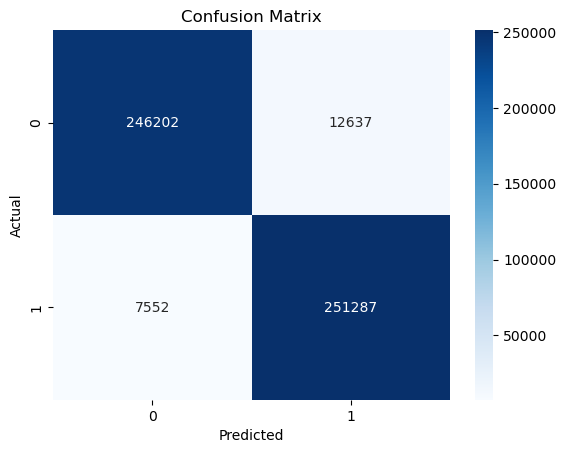

In [8]:
class EnhancedGNNModel(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate, activation_function, model_type='GCN', additional_layers=0):
        super(EnhancedGNNModel, self).__init__()
        if model_type == 'GCN':
            self.conv1 = GCNConv(num_features, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, hidden_dim)
        elif model_type == 'GraphSAGE':
            self.conv1 = SAGEConv(num_features, hidden_dim)
            self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        elif model_type == 'GAT':
            self.conv1 = GATConv(num_features, hidden_dim, heads=1)
            self.conv2 = GATConv(hidden_dim, hidden_dim, heads=1)
        else:
            raise ValueError("Invalid model type")

        self.additional_layers = nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(additional_layers)])

        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(p=dropout_rate)

        if activation_function == 'relu':
            self.activation = nn.ReLU()
        elif activation_function == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        elif activation_function == 'elu':
            self.activation = nn.ELU()
        elif activation_function == 'selu':
            self.activation = nn.SELU()
        else:
            raise ValueError("Invalid activation function")

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)

        for layer in self.additional_layers:
            x = layer(x, edge_index)
            x = self.activation(x)
            x = self.dropout(x)

        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Best configuration
best_params = {
    'hidden_dim': 124,
    'dropout_rate': 0.312041980613971,
    'lr': 0.007354486393031379,
    'activation_function': 'relu'
}
model_type = 'GAT'
additional_layers = 2
optimizer_class = optim.AdamW

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
val_aucs, val_accuracies, val_precisions, val_recalls, val_f1s = [], [], [], [], []
all_preds, all_labels = [], []

for train_idx, val_idx in skf.split(encoded_data_x, data_y):
    train_data = Data(x=encoded_data_x[train_idx], edge_index=edge_index, y=data_y[train_idx])
    val_data = Data(x=encoded_data_x[val_idx], edge_index=edge_index, y=data_y[val_idx])

    model = EnhancedGNNModel(
        num_features=encoded_data_x.shape[1],
        hidden_dim=best_params['hidden_dim'],
        num_classes=1,
        dropout_rate=best_params['dropout_rate'],
        activation_function=best_params['activation_function'],
        model_type=model_type,
        additional_layers=additional_layers
    ).to(device)

    optimizer = optimizer_class(model.parameters(), lr=best_params['lr'], weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    train_loader = DataLoader([train_data], batch_size=64, shuffle=True)
    val_loader = DataLoader([val_data], batch_size=64, shuffle=False)

    best_val_loss = float('inf')
    patience_counter = 0
    early_stopping_patience = 10

    model.train()
    for epoch in range(50):
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            out = out.view(-1)
            loss = criterion(out, batch.y.view(-1))
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_out = model(val_data.to(device))
            val_out = val_out.view(-1)
            val_loss = criterion(val_out, val_data.y.view(-1))

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= early_stopping_patience:
                break
        model.train()

    model.eval()
    with torch.no_grad():
        val_out = model(val_data.to(device))
        val_out = val_out.view(-1)
        val_preds = torch.sigmoid(val_out).round().cpu().numpy()
        val_labels = val_data.y.cpu().numpy()

        val_auc = roc_auc_score(val_labels, val_out.cpu().numpy())
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_precision = precision_score(val_labels, val_preds, zero_division=0)
        val_recall = recall_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds)
        val_roc_auc = roc_auc_score(val_labels, val_out.cpu().numpy())

        val_aucs.append(val_auc)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        all_preds.extend(val_preds)
        all_labels.extend(val_labels)

# Calculate mean metrics
mean_auc = np.mean(val_aucs)
mean_accuracy = np.mean(val_accuracies)
mean_precision = np.mean(val_precisions)
mean_recall = np.mean(val_recalls)
mean_f1 = np.mean(val_f1s)

print("Cross-Validation Results:")
print(f"Mean AUC: {mean_auc:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

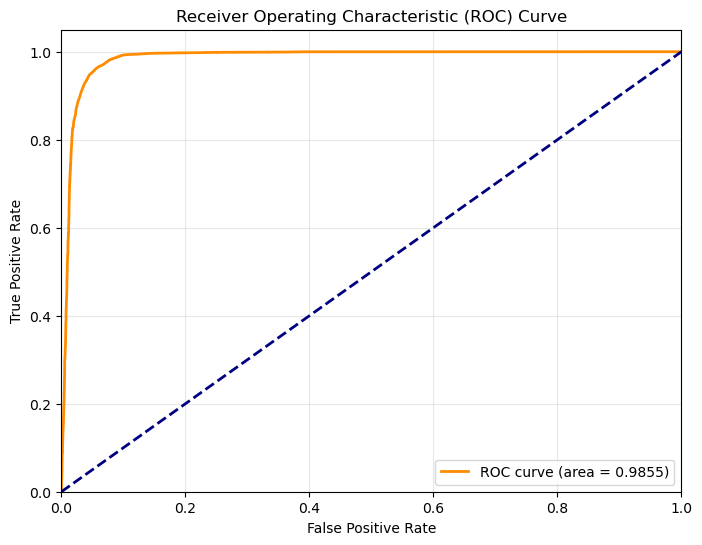

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming out_test and data_y contain the model predictions and true labels respectively
model.eval()
with torch.no_grad():
    out_test = model(Data(x=encoded_data_x, edge_index=edge_index, y=data_y).to(device))
    out_test = out_test.view(-1)
    preds_test_proba = torch.sigmoid(out_test).cpu().numpy()  # Probability predictions

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(data_y.cpu().numpy(), preds_test_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

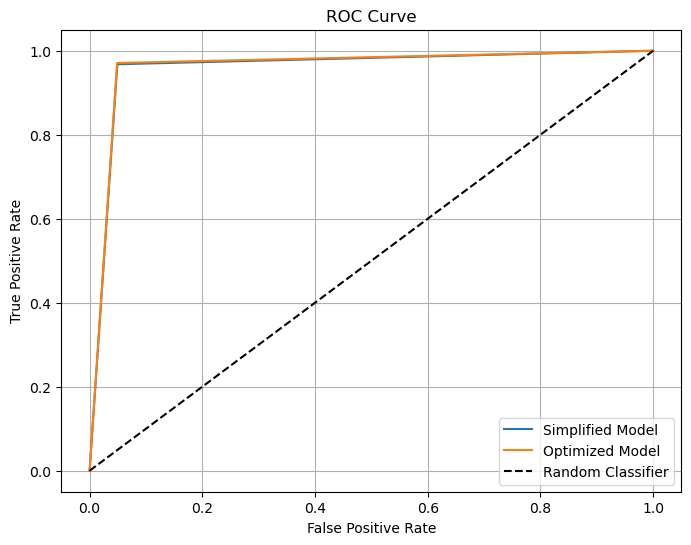

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Simplified model
TPR_simplified = 250498 / (250498 + 8341)
FPR_simplified = 12747 / (12747 + 246092)

# Optimized model
TPR_optimized = 251287 / (251287 + 7552)
FPR_optimized = 12637 / (12637 + 246202)

# Plotting the ROC curves
plt.figure(figsize=(8, 6))
plt.plot([0, FPR_simplified, 1], [0, TPR_simplified, 1], label='Simplified Model')
plt.plot([0, FPR_optimized, 1], [0, TPR_optimized, 1], label='Optimized Model')

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [10]:
# Save the trained model
model_path = 'optimized_gnn_model.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to optimized_gnn_model.pth


## Further experimentation

In [11]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('processed_data.csv')

if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

# Feature importance analysis using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(data_x, data_y)
importances = rf.feature_importances_

# Select top 8 features based on importance
indices = np.argsort(importances)[::-1][:8]
selected_features = [features[i] for i in indices]
data_x = data[selected_features].fillna(0).values

scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

smote = SMOTE()
data_x, data_y = smote.fit_resample(data_x, data_y)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        return out + residual

class ImprovedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(ImprovedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            ResidualBlock(256, 256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            ResidualBlock(128, 128),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            ResidualBlock(128, 128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            ResidualBlock(256, 256),
            nn.Linear(256, input_dim),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.dropout(x)
        x = self.decoder(x)
        return x

def train_improved_autoencoder(data_x, encoding_dim, num_epochs=50, learning_rate=0.001):
    input_dim = data_x.shape[1]
    autoencoder = ImprovedAutoencoder(input_dim, encoding_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    data_x_tensor = torch.tensor(data_x, dtype=torch.float).to(device)
    for epoch in range(num_epochs):
        autoencoder.train()
        optimizer.zero_grad()
        outputs = autoencoder(data_x_tensor)
        loss = criterion(outputs, data_x_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    encoded_data = autoencoder.encoder(data_x_tensor).detach().cpu().numpy()
    return encoded_data

encoding_dim = 64
encoded_data_x = train_improved_autoencoder(data_x, encoding_dim)
encoded_data_x = torch.tensor(encoded_data_x, dtype=torch.float)
data_y = torch.tensor(data_y, dtype=torch.float).unsqueeze(1)

unique_nodes = pd.Index(data['SENDER_ACCOUNT_ID'].append(data['RECEIVER_ACCOUNT_ID']).unique())
node_mapping = {node: i for i, node in enumerate(unique_nodes)}
data['SENDER_ID_REINDEX'] = data['SENDER_ACCOUNT_ID'].map(node_mapping)
data['RECEIVER_ID_REINDEX'] = data['RECEIVER_ACCOUNT_ID'].map(node_mapping)
edge_index = torch.tensor([data['SENDER_ID_REINDEX'].values, data['RECEIVER_ID_REINDEX'].values], dtype=torch.long)

Epoch [10/50], Loss: 0.3721
Epoch [20/50], Loss: 0.3045
Epoch [30/50], Loss: 0.2812
Epoch [40/50], Loss: 0.2779
Epoch [50/50], Loss: 0.2744


In [13]:
import optuna

class EnhancedGNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate, activation_function, model_type='GCN', additional_layers=0):
        super(EnhancedGNNModel, self).__init__()
        if model_type == 'GCN':
            self.conv1 = GCNConv(num_features, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, hidden_dim)
        elif model_type == 'GraphSAGE':
            self.conv1 = SAGEConv(num_features, hidden_dim)
            self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        elif model_type == 'GAT':
            self.conv1 = GATConv(num_features, hidden_dim, heads=1)
            self.conv2 = GATConv(hidden_dim, hidden_dim, heads=1)
        else:
            raise ValueError("Invalid model type")

        self.additional_layers = nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(additional_layers)])

        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

        if activation_function == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation_function == 'leaky_relu':
            self.activation = torch.nn.LeakyReLU()
        elif activation_function == 'elu':
            self.activation = torch.nn.ELU()
        elif activation_function == 'selu':
            self.activation = torch.nn.SELU()
        else:
            raise ValueError("Invalid activation function")

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)

        for layer in self.additional_layers:
            x = layer(x, edge_index)
            x = self.activation(x)
            x = self.dropout(x)

        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Top three hyperparameter sets
top_hyperparams = [
    {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'},
    {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'},
    {'hidden_dim': 124, 'dropout_rate': 0.312041980613971, 'lr': 0.007354486393031379, 'activation_function': 'relu'}
]

# Different model types and additional layers to experiment with
model_types = ['GCN', 'GraphSAGE', 'GAT']
additional_layers_options = [0, 1, 2]

# Different optimizers
optimizers = [optim.Adam, optim.AdamW, optim.RMSprop]

results = []

for params in top_hyperparams:
    for model_type in model_types:
        for additional_layers in additional_layers_options:
            for optimizer_class in optimizers:
                print(f"Testing with params: {params}, model_type: {model_type}, additional_layers: {additional_layers}, optimizer: {optimizer_class.__name__}")

                model = EnhancedGNNModel(
                    num_features=encoded_data_x.shape[1],
                    hidden_dim=params['hidden_dim'],
                    num_classes=1,
                    dropout_rate=params['dropout_rate'],
                    activation_function=params['activation_function'],
                    model_type=model_type,
                    additional_layers=additional_layers
                ).to(device)

                optimizer = optimizer_class(model.parameters(), lr=params['lr'], weight_decay=1e-4)
                criterion = torch.nn.BCEWithLogitsLoss()

                train_loader = DataLoader([Data(x=encoded_data_x, edge_index=edge_index, y=data_y)], batch_size=64, shuffle=True)

                best_auc = 0
                patience = 10
                trigger_times = 0

                for epoch in range(50):
                    for data in train_loader:
                        data = data.to(device)
                        optimizer.zero_grad()
                        out = model(data)
                        out = out.view(-1)
                        loss = criterion(out, data.y.view(-1))
                        loss.backward()
                        optimizer.step()

                    model.eval()
                    with torch.no_grad():
                        out_test = model(Data(x=encoded_data_x, edge_index=edge_index, y=data_y).to(device))
                        out_test = out_test.view(-1)
                        auc = roc_auc_score(data_y.cpu().numpy(), out_test.cpu().numpy())
                        if auc > best_auc:
                            best_auc = auc
                            trigger_times = 0
                        else:
                            trigger_times += 1
                        if trigger_times >= patience:
                            break
                    model.train()

                model.eval()
                with torch.no_grad():
                    out_test = model(Data(x=encoded_data_x, edge_index=edge_index, y=data_y).to(device))
                    out_test = out_test.view(-1)
                    preds_test = torch.sigmoid(out_test).round()
                    accuracy_test = accuracy_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
                    precision_test = precision_score(data_y.cpu().numpy(), preds_test.cpu().numpy(), zero_division=0)
                    recall_test = recall_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
                    f1_test = f1_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
                    roc_auc_test = roc_auc_score(data_y.cpu().numpy(), out_test.cpu().numpy())

                results.append({
                    'params': params,
                    'model_type': model_type,
                    'additional_layers': additional_layers,
                    'optimizer': optimizer_class.__name__,
                    'AUC': auc,
                    'Accuracy': accuracy_test,
                    'Precision': precision_test,
                    'Recall': recall_test,
                    'F1 Score': f1_test,
                    'ROC AUC': roc_auc_test
                })

# Find the best configuration
best_result = max(results, key=lambda x: (x['AUC'], x['Accuracy'], x['Precision'], x['Recall'], x['F1 Score']))

print("Best configuration:")
print(best_result)

Testing with params: {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, model_type: GCN, additional_layers: 0, optimizer: Adam
Testing with params: {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, model_type: GCN, additional_layers: 0, optimizer: AdamW
Testing with params: {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, model_type: GCN, additional_layers: 0, optimizer: RMSprop
Testing with params: {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, model_type: GCN, additional_layers: 1, optimizer: Adam
Testing with params: {'hidden_dim': 128, 'dropout_rate': 0.31493056229763705, 'lr': 0.007121467603210732, 'activation_function': 'relu'}, model_type: GCN, additional_layers: 1, optimizer: AdamW
Testing with params: {'hidden_

Testing with params: {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, model_type: GraphSAGE, additional_layers: 2, optimizer: Adam
Testing with params: {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, model_type: GraphSAGE, additional_layers: 2, optimizer: AdamW
Testing with params: {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, model_type: GraphSAGE, additional_layers: 2, optimizer: RMSprop
Testing with params: {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, model_type: GAT, additional_layers: 0, optimizer: Adam
Testing with params: {'hidden_dim': 123, 'dropout_rate': 0.3194954963334946, 'lr': 0.007462289534750929, 'activation_function': 'relu'}, model_type: GAT, additional_layers: 0, optimizer: AdamW
Testing with para

Epoch [10/50], Loss: 0.3208
Epoch [20/50], Loss: 0.2895
Epoch [30/50], Loss: 0.2812
Epoch [40/50], Loss: 0.2774
Epoch [50/50], Loss: 0.2756
Final Model Performance:
  AUC: 0.9885
  Accuracy: 0.9636
  Precision: 0.9471
  Recall: 0.9821
  F1 Score: 0.9643
  ROC AUC: 0.9885


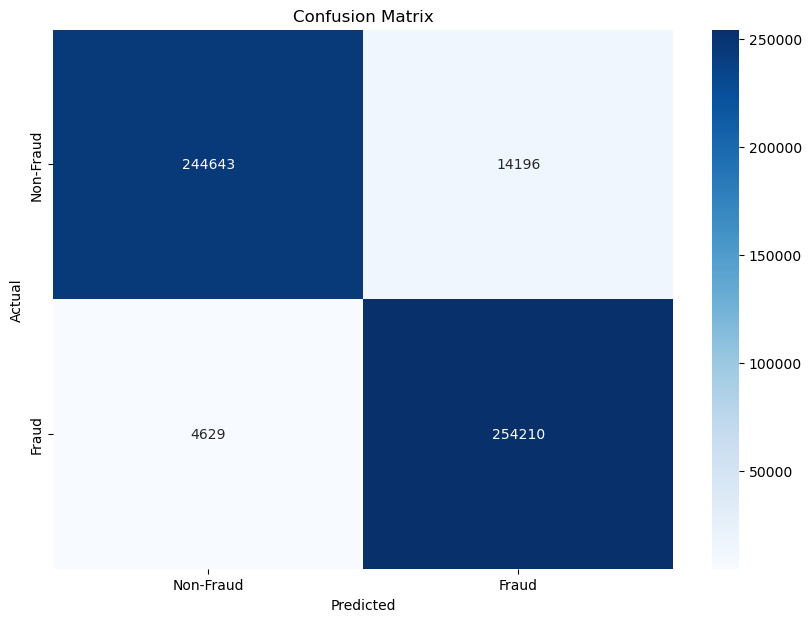

In [14]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
data = pd.read_csv('processed_data.csv')

if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

# Feature importance analysis using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(data_x, data_y)
importances = rf.feature_importances_

# Select top 8 features based on importance
indices = np.argsort(importances)[::-1][:8]
selected_features = [features[i] for i in indices]
data_x = data[selected_features].fillna(0).values

scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

smote = SMOTE()
data_x, data_y = smote.fit_resample(data_x, data_y)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        return out + residual

class ImprovedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(ImprovedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            ResidualBlock(256, 256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            ResidualBlock(128, 128),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            ResidualBlock(128, 128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            ResidualBlock(256, 256),
            nn.Linear(256, input_dim),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.dropout(x)
        x = self.decoder(x)
        return x

def train_improved_autoencoder(data_x, encoding_dim, num_epochs=50, learning_rate=0.001):
    input_dim = data_x.shape[1]
    autoencoder = ImprovedAutoencoder(input_dim, encoding_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    data_x_tensor = torch.tensor(data_x, dtype=torch.float).to(device)
    for epoch in range(num_epochs):
        autoencoder.train()
        optimizer.zero_grad()
        outputs = autoencoder(data_x_tensor)
        loss = criterion(outputs, data_x_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    encoded_data = autoencoder.encoder(data_x_tensor).detach().cpu().numpy()
    return encoded_data

encoding_dim = 64
encoded_data_x = train_improved_autoencoder(data_x, encoding_dim)
encoded_data_x = torch.tensor(encoded_data_x, dtype=torch.float)
data_y = torch.tensor(data_y, dtype=torch.float).unsqueeze(1)

unique_nodes = pd.Index(data['SENDER_ACCOUNT_ID'].append(data['RECEIVER_ACCOUNT_ID']).unique())
node_mapping = {node: i for i, node in enumerate(unique_nodes)}
data['SENDER_ID_REINDEX'] = data['SENDER_ACCOUNT_ID'].map(node_mapping)
data['RECEIVER_ID_REINDEX'] = data['RECEIVER_ACCOUNT_ID'].map(node_mapping)
edge_index = torch.tensor([data['SENDER_ID_REINDEX'].values, data['RECEIVER_ID_REINDEX'].values], dtype=torch.long)

# Define the EnhancedGNNModel class again for use in the optimization
class EnhancedGNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate, activation_function, model_type='GAT', additional_layers=1):
        super(EnhancedGNNModel, self).__init__()
        if model_type == 'GCN':
            self.conv1 = GCNConv(num_features, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, hidden_dim)
        elif model_type == 'GraphSAGE':
            self.conv1 = SAGEConv(num_features, hidden_dim)
            self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        elif model_type == 'GAT':
            self.conv1 = GATConv(num_features, hidden_dim, heads=1)
            self.conv2 = GATConv(hidden_dim, hidden_dim, heads=1)
        else:
            raise ValueError("Invalid model type")

        self.additional_layers = nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(additional_layers)])

        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

        if activation_function == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation_function == 'leaky_relu':
            self.activation = torch.nn.LeakyReLU()
        elif activation_function == 'elu':
            self.activation = torch.nn.ELU()
        elif activation_function == 'selu':
            self.activation = torch.nn.SELU()
        else:
            raise ValueError("Invalid activation function")

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)

        for layer in self.additional_layers:
            x = layer(x, edge_index)
            x = self.activation(x)
            x = self.dropout(x)

        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define and train the final model
best_params = {
    'hidden_dim': 124,
    'dropout_rate': 0.312041980613971,
    'lr': 0.007354486393031379,
    'activation_function': 'relu'
}
model_type = 'GAT'
additional_layers = 1
optimizer_class = optim.AdamW

model = EnhancedGNNModel(
    num_features=encoded_data_x.shape[1],
    hidden_dim=best_params['hidden_dim'],
    num_classes=1,
    dropout_rate=best_params['dropout_rate'],
    activation_function=best_params['activation_function'],
    model_type=model_type,
    additional_layers=additional_layers
).to(device)

optimizer = optimizer_class(model.parameters(), lr=best_params['lr'], weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

train_loader = DataLoader([Data(x=encoded_data_x, edge_index=edge_index, y=data_y)], batch_size=64, shuffle=True)

best_auc = 0
patience = 10
trigger_times = 0

for epoch in range(50):
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        out = out.view(-1)
        loss = criterion(out, data.y.view(-1))
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        out_test = model(Data(x=encoded_data_x, edge_index=edge_index, y=data_y).to(device))
        out_test = out_test.view(-1)
        auc = roc_auc_score(data_y.cpu().numpy(), out_test.cpu().numpy())
        if auc > best_auc:
            best_auc = auc
            trigger_times = 0
        else:
            trigger_times += 1
        if trigger_times >= patience:
            break
    model.train()

model.eval()
with torch.no_grad():
    out_test = model(Data(x=encoded_data_x, edge_index=edge_index, y=data_y).to(device))
    out_test = out_test.view(-1)
    preds_test = torch.sigmoid(out_test).round()
    accuracy_test = accuracy_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
    precision_test = precision_score(data_y.cpu().numpy(), preds_test.cpu().numpy(), zero_division=0)
    recall_test = recall_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
    f1_test = f1_score(data_y.cpu().numpy(), preds_test.cpu().numpy())
    roc_auc_test = roc_auc_score(data_y.cpu().numpy(), out_test.cpu().numpy())
    conf_matrix = confusion_matrix(data_y.cpu().numpy(), preds_test.cpu().numpy())

print(f'Final Model Performance:')
print(f'  AUC: {auc:.4f}')
print(f'  Accuracy: {accuracy_test:.4f}')
print(f'  Precision: {precision_test:.4f}')
print(f'  Recall: {recall_test:.4f}')
print(f'  F1 Score: {f1_test:.4f}')
print(f'  ROC AUC: {roc_auc_test:.4f}')

# Confusion Matrix Visualization
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the final model
torch.save(model.state_dict(), 'optimized_gnn_model.pth')